In [1]:
import pandas as pd
import itertools, nltk, string 
import requests, re
from nltk import Tree
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
import os
import spacy
from gensim.models.wrappers import FastText
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, roc_curve
import matplotlib.pyplot as plt
from math import exp, expm1, log, log10
from scipy.spatial.distance import euclidean
import numpy as np
from scipy.optimize import minimize
from scipy.spatial.distance import cdist

import ast



from sklearn.metrics import average_precision_score,accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score
from collections import OrderedDict
import numpy as np
import math
import statistics
from pywsd.lesk import simple_lesk
from nltk.corpus import sentiwordnet as swn
from nltk.parse.corenlp import CoreNLPDependencyParser
parser = CoreNLPDependencyParser()



wordnet_lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
snowball_stemmer = SnowballStemmer("english")

Warming up PyWSD (takes ~10 secs)... took 8.371055841445923 secs.


In [2]:
positive_lexicon = []
negative_lexicon = []

def read_lexicon():
    global positive_lexicon;
    global negative_lexicon;
    
    with open(os.path.join(os.path.abspath('../opinion-lexicon-English/') , 'positive-words.txt'), 'r') as file:
        line = file.readline();
        while ";" in line:
            line = file.readline();
         
        positive_lexicon = file.readlines()
    
    with open(os.path.join(os.path.abspath('../opinion-lexicon-English/') , 'negative-words.txt'), 'r', encoding = "ISO-8859-1") as file:
        line = file.readline();
        while ";" in line:
            line = file.readline();
        
        negative_lexicon = file.readlines()
        
    positive_lexicon = list(map(lambda word: word.rstrip("\n\r"), positive_lexicon))
    negative_lexicon = list(map(lambda word: word.rstrip("\n\r"), negative_lexicon))

read_lexicon()

In [3]:
#load function

linking_verbs_be = [
    'be',
    'is',
    'are',
    'am',
    'was',
    'were',
    'can be',
    'could be',
    'will be',
    'would be',
    'shall be',
    'should be',
    'may be',
    'might be',
    'must be',
    'has been',
    'have been',
    'had been'
];

linking_verbs_v = [
    'feel',
    'look',
    'smell',
    'sound',
    'taste',
    'act',
    'appear',
    'become',
    'get',
    'grow',
    'prove',
    'remain', 
    'seem',
    'stay',
    'turn'
];

def check_is_noun(pos):
    return re.match('NN.*', pos)

def check_is_prp(pos):
    return re.match('PRP.*', pos)

def check_is_verb(pos):
    return re.match('VB.*', pos)

def check_is_adjective(pos):
    return re.match('JJ.*', pos)

def check_is_adverb(pos):
    return re.match('RB.*', pos)

def lemmatize(word, pos):
    tag = None#wn.NOUN
    if(check_is_noun(pos)):
        tag = wn.NOUN
    elif(check_is_verb(pos)):
        tag = wn.VERB
    elif(check_is_adjective(pos)):
        tag = wn.ADJ
    elif(check_is_adverb(pos)):
        tag = wn.ADV
    if tag:        
        lemma = wordnet_lemmatizer.lemmatize(word, tag)
    else:
        lemma = word
    return lemma


def preprocessing(sentence):
    res = sentence.replace("'m", "am").replace("n't", " not").replace("dont", "do not").replace("’s", ' is').replace("'s", ' is').replace("'ve", " have").lower()
    res = re.sub(r'\b\d+\b', 'NUM', res)
    res = re.sub(r'(.)\1{3,}', '', res)
    to_delete_punc = set(string.punctuation) - {',', '.', '(', ')', '-'} # remove comma and fullstop
    clean_tokens = [x for x in nltk.word_tokenize(res) if x not in to_delete_punc]

    return " ".join(clean_tokens)

def preprocessing_with_lemma(sentence):
    res = re.sub(r'[^\w\s]',' ', sentence.replace("'m", "am").replace("n't", "not").replace("dont", "do not").replace("'ve", " have").replace("'s", ' is').replace("’s", ' is')).lower()
    res = re.sub(r'(.)\1{3,}', '', res)
   
    #checking for parallel clauses
    #splitted = res.split(', and but')
    res = re.sub(r'\b\d+\b', '', res)
    tagged_words = pos_tag(res.encode())
    lemma = []
    for word, pos in tagged_words:
        if word not in stopWords:
            lemma.append(lemmatize(word, pos)) 
        
    return " ".join(lemma)
    
def pos_tag(sentence):
    '''url = "http://localhost:9000"
    request_params = {"annotators": "pos"}
    r = requests.post(url, data=sentence, params=request_params, timeout=120)
    try:
        results = r.json()['sentences'][0]['tokens']
        res = []
        for pos in results:
            res.append((pos['word'], pos['pos']))
        return res
    except Exception as e:
        print(e)
        return []
    '''
    return nltk.pos_tag(nltk.word_tokenize(sentence))
    
def get_tregex(text, tregex):
    url = "http://localhost:9000/tregex"
    request_params = {"pattern": tregex}
    r = requests.post(url, data=text, params=request_params, timeout=120)
    try:
        return r.json()['sentences'][0]
    except:
        return []

def sentence_from_tree(s):
    pattern = r'(?<= )[a-zA-Z,.].*?(?=\))'
    replaced = s.replace('\r\n', '')
    res = ' '.join(re.findall(pattern, replaced))
    return res
        
def sentence_type(clauses):
    IC = 0
    DC = 0
    for clause in clauses:
        if(clause[1] == 'IC'):
            IC += 1
        elif(clause[1] == 'DC'):
            DC += 1

    if IC == 1 and DC == 0:
        return 'simple_sentence'
    elif IC >= 2 and DC == 0:
        return 'compound_sentence'
    elif IC ==1 and DC >= 1:
        return 'complex_sentence'
    elif IC > 1 and DC >= 1:
        return 'compound_complex_sentence'
    else:
        return 'phrase'
    

In [4]:
def geometric_medianX(points, method='auto', options={}):
    """
    Calculates the geometric median of an array of points.
    method specifies which algorithm to use:
        * 'auto' -- uses a heuristic to pick an algorithm
        * 'minimize' -- scipy.optimize the sum of distances
        * 'weiszfeld' -- Weiszfeld's algorithm
    """

    points = np.asarray(points)

    if len(points.shape) == 1:
        # geometric_median((0, 0)) has too much potential for error.
        # Did the user intend a single 2D point or two scalars?
        # Use np.median if you meant the latter.
        raise ValueError("Expected 2D array")

    if method == 'auto':
        if points.shape[1] > 2:
            # weiszfeld tends to converge faster in higher dimensions
            method = 'weiszfeld'
        else:
            method = 'minimize'

    return _methods[method](points, options)


def minimize_method(points, options={}):
    """
    Geometric median as a convex optimization problem.
    """

    # objective function
    def aggregate_distance(x):
        return cdist([x], points).sum()

    # initial guess: centroid
    centroid = points.mean(axis=0)

    optimize_result = minimize(aggregate_distance, centroid, method='COBYLA')

    return optimize_result.x


def weiszfeld_method(points, options={}):
    """
    Weiszfeld's algorithm as described on Wikipedia.
    """

    default_options = {'maxiter': 1000, 'tol': 1e-7}
    default_options.update(options)
    options = default_options

    def distance_func(x):
        return cdist([x], points)

    # initial guess: centroid
    guess = points.mean(axis=0)

    iters = 0

    while iters < options['maxiter']:
        distances = distance_func(guess).T

        # catch divide by zero
        # TODO: Wikipedia cites how to deal with distance 0
        distances = np.where(distances == 0, 1, distances)

        guess_next = (points/distances).sum(axis=0) / (1./distances).sum(axis=0)

        guess_movement = np.sqrt(((guess - guess_next)**2).sum())

        guess = guess_next

        if guess_movement <= options['tol']:
            break

        iters += 1

    return guess


_methods = {
    'minimize': minimize_method,
    'weiszfeld': weiszfeld_method,
}

In [426]:
def graph(radii, theta, key, show_pic=False):
    i=0
    a=[]
    b=[]
    rad=list(radii.values())
    theta1=list(theta.values())
    index = []
    while(i<len(radii)):
        if(theta1[i] != 0):
            a.append(rad[i]*math.cos(theta1[i]))
            b.append(rad[i]*math.sin(theta1[i]))
            index.append(i)
        i+=1 
        
    if show_pic:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot([0,0],[-1,1])
        plt.plot([-1,1],[0,0])
        plt.axis([-1,1,-1,1])

        plt.scatter(a,b,label="circles",color="r",marker="o",s=10)
        q = 0
        rad2=list(radii.keys())
        for i,j,z in zip(a,b, index):
            #ax.annotate('%s' %rad2[z], xy=(i,j), xytext=(15,0), textcoords='offset points')
            ax.annotate('%s' %'', xy=(i,j), xytext=(15,0), textcoords='offset points')
            
            q = q+1    
        
        points = []
        for x,y in zip(a,b):
            points.append([x, y])
        
        if(len(points) == 0):
            points.append([0, 0])
            
        senti_x, senti_y = geometric_medianX(points)
        plt.scatter(senti_x,senti_y,label="circles",color="b",marker="o",s=10)
        ax.annotate('%s' % '', xy=(senti_x,senti_y), xytext=(15,0), textcoords='offset points')
           
        ax.add_artist(plt.Circle((0,0),1.0,color='b',fill=False))
        plt.xlabel('Sentiment Strength')
        plt.ylabel('Orientation')
        plt.title(key)
        plt.savefig("graph.png")
    
    return a,b

In [424]:
negation = [
    "afraid",
    "can't",
    "cannot",
    "deny",
    "mean",
    "negate",
    "negation",
    "but",
    "negative",
    "neither",
    "never",
    "no",
    "non",
    "none",
    "nor",
    "not",
    "nothing",
    "refusal",
    "refuse",
    "reject",
    "rejection",
  #  'even',
  #  'although'
]


def analyse_file(key, lines, lemma_lines, usingSynonym=False, usingCoocurrence=False):    
    radii, synonym_keys, coocurrence_keys = get_TDOC(lines, key, lemma_lines, usingSynonym, usingCoocurrence)    
    return radii, synonym_keys, coocurrence_keys

def get_TDOC(lines, key, lemma_lines, usingSynonym=False, usingCoocurrence=False, synonym_keys={}, coocurrence_keys={}):
    freq = {'Init': 0}              #Number of times context term occurs with key
    freq.clear()
    prohib = ['even', 'main'] #stopWords
    for line in lemma_lines:
        words = line.split(" ")
        tagged = pos_tag(line)
        if key in words:
            if usingSynonym:
                syn_c=[]
                for context, pos in tagged:
                    try:
                        synonym_keys.setdefault(context, [])
                                    
                        for i, syn in enumerate(wn.synsets(context)):
                            if i > 4:
                                break
                            
                            if(syn.pos() != wn.NOUN):
                                for l in syn.lemmas():
                                    if not '-' in l.name():
                                        if(l.name() not in synonym_keys[context]):
                                            synonym_keys[context].append(l.name())
                                        syn_c.append(l.name())

                    except:
                        #print(context)
                        #print('error')
                        pass
                for c in syn_c:
                    words.append(c)
            for context in words:
                flag=0
                for i in prohib:
                    if i == context:
                        flag=1
                        break
                if flag==0 and context!=key:# and context in op_set:
                    freq.setdefault(context, 0)
                    freq[context] = freq.get(context) + 1
                                           
    N = 0                           #Total Number of terms in Document
    for line in lemma_lines:
        words = line.split(" ")
        N += len(words)
    #print(freq)
    if usingCoocurrence:
        di = {}
        coocurrence_keys.setdefault(key, [])
        it = 0
        for key_n in freq.keys():
            tg = pos_tag(key_n)
            #if it > 5:
            #    break;
            if( check_is_adjective(tg[0][1]) or (key_n in positive_lexicon or key_n in negative_lexicon)):
                for line in lemma_lines:
                    words = line.split(" ")
                    tagged = pos_tag(line)
                    
                    if key_n in words:
                        for x in range(0, len(words)):
                            try:
                                #if (words[x+1] == key_n) or (words[x+2] == key_n) or (words[x+3] == key_n) or (words[x-1] == key_n):
                                if check_is_adjective(tagged[x][1]):
                                    di.setdefault(words[x], 0)
                                    di[words[x]] = di.get(words[x]) + 1
                                    if words[x] not in coocurrence_keys[key]:
                                        coocurrence_keys[key].append(words[x])
                            except:
                                pass
               
        freq.update(di)
        
    Nci = {'Init': 0}               #Total terms that occur with context term
    Nci.clear()
    for context in freq.keys():
        for line in lemma_lines:
            words = line.split(" ")
            if context in words:
                Nci.setdefault(context, 0)
                Nci[context] += len(words)
                
    if usingSynonym:
        for context in freq.keys():
            if context not in Nci.keys():
                Nci.setdefault(context, 1)

    radii = {'Init': 0}             #Get Radius of context term with TDOC formula
    radii.clear()
    #print('freq', freq)
    #print('N', N)
    #print('NCI', Nci)
    df = pd.DataFrame(columns=['c', 'm', 'N', 'Nc', 'f', 'N/Nc', 'log(N/Nc)', 'fxlog(N/Nc)', '/4'])
    max_value = 0
    for term in freq.keys():
        radii[term] = (freq[term]*(log(N/Nci[term])))
        
        if radii[term] > max_value:
            max_value = radii[term]
        
    for term in freq.keys():
        radii[term] = radii[term]/max_value
        
        df = df.append({'c': term,
                'm': key,
                'N': N,
                'Nc': Nci[term],
                'f': freq[term],
                'N/Nc': "{0:.2f}".format(N/Nci[term]),
                'log(N/Nc)': "{0:.2f}".format(log(N/Nci[term])),
                'fxlog(N/Nc)': "{0:.2f}".format(freq[term]*(log(N/Nci[term]))),
                'normalisasi': "{0:.2f}".format((freq[term]*(log(N/Nci[term])))/max_value)
               }, ignore_index=True)
    
    #df.to_excel("tdoc2.xlsx")
    return radii, synonym_keys, coocurrence_keys                  #Returns entire set of context terms related to key

def get_theta(key, sentences):
    scores = []
    for sentence in sentences:
        flag = True
        
        pp_tagged = pos_tag(sentence)
        tagged = ('','')
        for p in pp_tagged:
            if p[0] == key:
                tagged = p
        if tagged == ('', ''):
            flag = False
        
        ambiguous = tagged[0]
        tag = tagged[1]
        pos = ''

        if 'NN' in tag or 'NNS' in tag:
            pos = 'n'
        elif 'VB' in tag:
            pos = 'v'
        elif 'VBG' in tag:
            pos = 'v'
        elif 'JJ' in tag:
            pos = 'a'
        elif 'RB' in tag:
            pos = 'r'
        else:
            flag = False

        if flag:
            if ambiguous in negation or pos == 'n' or pos == 'v' or pos == 'r':
                scores.append(0)
                continue
             
            try:
                 answer = simple_lesk(sentence, ambiguous, pos)
            except Exception as e:
                print(e)
                answer = None
                
            if answer:
                score = swn.senti_synset(answer.name())
                #print(score, sentence, ambiguous)
                endscore = 0
                if score.pos_score() > score.neg_score():
                    endscore = score.pos_score()
                elif score.neg_score() > score.pos_score():
                    endscore = score.neg_score() * (-1)
                else:
                    endscore = 0
                
                words = sentence.split(' ')
                word_around = []
                for x in range(0, len(words)):
                    if words[x] in string.punctuation:
                        continue
                    try:
                        if (words[x+1] == key) or (words[x+2] == key) or (words[x+3] == key) or (words[x+4] == key):
                            word_around.append(words[x])
                        elif (words[x-1] == key):
                            word_around.append(words[x])
                    except:
                        pass
                #print(word_around, key)
                for neg in negation:
                    if neg in word_around:
                       # print('masuk', endscore, key, score)
                        endscore *= (-1)
                        break
                        
                scores.append(endscore)
            else:
                scores.append(0)
        else:
            scores.append(0)
    final_score = np.average(scores)
    
    return np.pi * final_score

def prior_sentiment(radii, key, all_sentences, sentence_lemmas, usingSynonym=False, usingCoocurrence=False, synonym_keys={}, coocurrence_keys={}):
    theta = {'Init': 0}
    theta.clear()
    #print('masuk prior', synonym_keys, usingSynonym)
    for word in radii.keys():
        sentences = []
        for sentence, sentence_lemma in zip(all_sentences, sentence_lemmas):
            words = sentence_lemma.split(' ')
            if key in words:
                
                if usingSynonym:
                    child_syns = synonym_keys[key]
                    
                    if word in child_syns:
                        words.append(word)
                        sentence = sentence.replace(key, word)
                        
                   
                if (word in words):
                    sentences.append(sentence)
                            
            if usingCoocurrence:
             
                if word in words and word != key:
                   # print(sentence, k)
                    if sentence not in sentences:
                        sentences.append(sentence)
            #      
            #            print(sentences, k, key)
            #            sentences.append(sentence)
                        
        
        #print("+++", sentences, "+++")
        if(len(sentences) > 0):
           # print(word, sentences)
            filter = get_theta(word, sentences)            #if function returns 0 word does not exist in lexicon
            #print('hore')
        else:
            #print('kok bisa', word)
            filter = 0.0
        theta[word] = filter
        #print('---', theta[word], '---')
        
    return theta

In [514]:
def senti(keys, lines, lemma_lines, usingSynonym=False, usingCoocurrence=False):
    points_k = []
    for key in keys:
        if key in memoize:
            radii = memoize[key]['radii']
            theta = memoize[key]['theta']
        else:
            radii, synonym_keys, coocurrence_keys = analyse_file(key, lines, lemma_lines, usingSynonym, usingCoocurrence)
            #print(synonym_keys)
            theta = prior_sentiment(radii, key, lines, lemma_lines, usingSynonym, usingCoocurrence, synonym_keys, coocurrence_keys)
            memoize.setdefault(key, {})
                   
            memoize[key]['radii'] = radii
            memoize[key]['theta'] = theta
            #print(radii,theta)
            
        a,b = graph(radii, theta, key, True)
        points = []
        for x,y in zip(a,b):
            points.append([x, y])
        
        if(len(points) == 0):
            points.append([0, 0])
        senti_x, senti_y = geometric_medianX(points)
        
        points_k.append([senti_x, senti_y])
    
    sentiment_strength, sentiment_orientation = geometric_medianX(points_k)
    #print(sentiment_strength, sentiment_orientation)
    if sentiment_orientation > 0:
        return 'positive', sentiment_orientation
    else:
        return 'negative', sentiment_orientation

In [8]:
def categorize_dataset(category, dataset):
    return dataset[dataset.apply(lambda x: set([category]).issubset(ast.literal_eval(x['entity_prediction'])), axis=1)].reset_index(drop=True)

In [445]:
def confusion_metrix_sentiment_senticircle(selected, dataset):
    tp = 0
    tn = 0
    fp = 0
    fn = 0 
    
    for i, predictions in enumerate(dataset['opinion_prediction']):
        target = dataset['polarity'][i]
        
        entity_predictions =  ast.literal_eval(dataset['entity_prediction'][i])
        #print(entity_predictions, predictions)
        #print(entity_predictions)
        entities = dataset['entity'][i].split(',')
        pred_selected = None
        actual_selected = None
        
        for index, pred in enumerate(predictions):
           # print(pred)
            if entity_predictions[index] == selected:
                if pred == 'positive':
                    pred_selected = True
                else:
                    pred_selected = False
        
        for index, ent in enumerate(target.split(',')):
            if entities[index] == selected:
                if ent == 'positive':
                    actual_selected = True
                else:
                    actual_selected = False
        if pred_selected is None or actual_selected is None:
            continue
            
        #print(pred_selected, actual_selected, entity_predictions, entities, target, predictions)
        if pred_selected and actual_selected:
            tp +=1
        elif pred_selected and not actual_selected:   
            fp += 1
        elif not pred_selected and actual_selected:
            fn += 1
        elif not pred_selected and not actual_selected:
            tn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return tp, tn, fp, fn, precision, recall, ((precision * recall) / (precision + recall)) * 2

In [10]:
data_ac3 = pd.read_csv('ac3.csv')

In [11]:
data_food = pd.read_csv('food.csv')#categorize_dataset('FOOD', data_ac3)

In [12]:
data_value = pd.read_csv('value.csv')#categorize_dataset('VALUE', data_ac3)

In [13]:
data_ambience = categorize_dataset('AMBIENCE', data_ac3)

In [14]:
data_service = categorize_dataset('SERVICE', data_ac3)

SA1

In [347]:
op_pred = []
memoize = {}
for i, opinion_sents in enumerate(data_food['opinion_term_prediction']):
    temp = []
    opinion_sents = ast.literal_eval(opinion_sents)
    for opinions in opinion_sents:
        temp.append(senti(opinions, data_food['preprocessed_sentence'].tolist(), data_food['preprocessed_sentence_lemma'].tolist()))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_food['opinion_prediction'] = op_pred

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

In [348]:
op_pred = []
memoize = {}
for i, opinion_sents in enumerate(data_ambience['opinion_term_prediction']):
    temp = []
    opinion_sents = ast.literal_eval(opinion_sents)
    for opinions in opinion_sents:
        temp.append(senti(opinions, data_ambience['preprocessed_sentence'].tolist(), data_ambience['preprocessed_sentence_lemma'].tolist()))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_ambience['opinion_prediction'] = op_pred

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range


In [349]:
op_pred = []
memoize = {}
for i, opinion_sents in enumerate(data_service['opinion_term_prediction']):
    temp = []
    opinion_sents = ast.literal_eval(opinion_sents)
    for opinions in opinion_sents:
        temp.append(senti(opinions, data_service['preprocessed_sentence'].tolist(), data_service['preprocessed_sentence_lemma'].tolist()))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_service['opinion_prediction'] = op_pred

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range


In [350]:
op_pred = []
memoize = {}
for i, opinion_sents in enumerate(data_value['opinion_term_prediction']):
    temp = []
    opinion_sents = ast.literal_eval(opinion_sents)
    for opinions in opinion_sents:
        temp.append(senti(opinions, data_value['preprocessed_sentence'].tolist(), data_value['preprocessed_sentence_lemma'].tolist()))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_value['opinion_prediction'] = op_pred

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range


In [351]:
sentiment_value = (confusion_metrix_sentiment_senticircle('VALUE', data_value)[6]) #+ confusion_metrix_sentiment_senticircle('negative', data_value)[6] ) / 2
print(sentiment_value)

0.7770700636942676


In [352]:
sentiment_ambience = (confusion_metrix_sentiment_senticircle('AMBIENCE', data_ambience)[6])# + confusion_metrix_sentiment_senticircle('negative', data_ambience)[6] ) / 2
print(sentiment_ambience)

0.8979591836734694


In [353]:
sentiment_food = (confusion_metrix_sentiment_senticircle('FOOD', data_food)[6])# + confusion_metrix_sentiment_senticircle('negative', data_food)[6] ) / 2
print(sentiment_food)

0.6571428571428571


In [354]:
sentiment_service = (confusion_metrix_sentiment_senticircle('SERVICE', data_service)[6])# + confusion_metrix_sentiment_senticircle('negative', data_service)[6] ) / 2
print(sentiment_service)

0.8934010152284264


In [355]:
(sentiment_value + sentiment_ambience + sentiment_food + sentiment_service) / 4

0.8063932799347551

In [356]:
data_food.to_csv('SA1_food.csv')
data_ambience.to_csv('SA1_ambience.csv')
data_value.to_csv('SA1_value.csv')
data_service.to_csv('SA1_service.csv')

SA2

In [362]:
op_pred = []
op_score = []
memoize = {}
for i, opinion_sents in enumerate(data_food['opinion_term_prediction']):
    temp = []
    temp1 = []
    opinion_sents = ast.literal_eval(opinion_sents)
    for opinions in opinion_sents:
        polarity, senti_score =  senti(opinions, data_food['preprocessed_sentence'].tolist(), data_food['preprocessed_sentence_lemma'].tolist(), True)
        temp.append(polarity)
        temp1.append(senti_score)
    op_pred.append(temp)
    op_score.append(temp1)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_food['opinion_prediction'] = op_pred
data_food['senti_score'] = op_score

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

In [363]:
op_pred = []
op_score = []

memoize = {}
for i, opinion_sents in enumerate(data_ambience['opinion_term_prediction']):
    temp = []
    temp1 = []
    
    opinion_sents = ast.literal_eval(opinion_sents)
    for opinions in opinion_sents:
        polarity, senti_score = senti(opinions, data_ambience['preprocessed_sentence'].tolist(), data_ambience['preprocessed_sentence_lemma'].tolist(), True)
        temp.append(polarity)
        temp1.append(senti_score)
    op_pred.append(temp)
    op_score.append(temp1)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_ambience['opinion_prediction'] = op_pred
data_ambience['senti_score'] = op_score

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

list index out of range
list index out of range
0.28744465804190644
-0.07262596107616376
-0.07262596107616376


KeyboardInterrupt: 

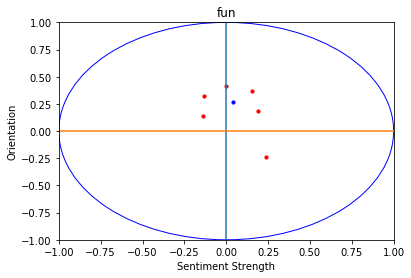

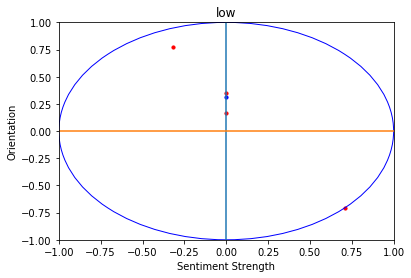

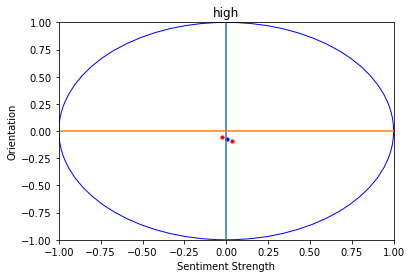

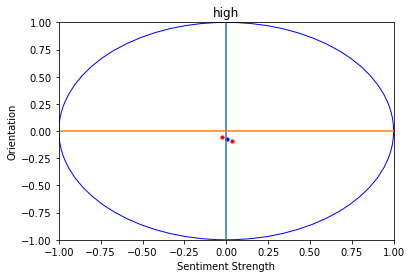

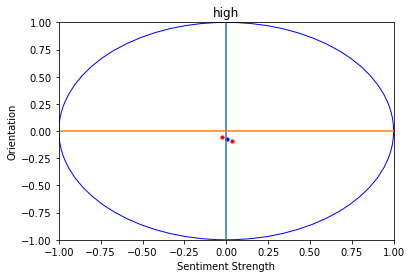

In [511]:
op_pred = []
op_score = []

memoize = {}
for i, opinion_sents in enumerate(data_value['opinion_term_prediction']):
    temp = []
    temp1 = []
    
    opinion_sents = ast.literal_eval(opinion_sents)
    for opinions in opinion_sents:
        polarity, senti_score = senti(opinions, data_value['preprocessed_sentence'].tolist(), data_value['preprocessed_sentence_lemma'].tolist(), True)
        temp.append(polarity)
        temp1.append(senti_score)
    op_pred.append(temp)
    op_score.append(temp1)
    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_value['opinion_prediction'] = op_pred
data_value['senti_score'] = op_score

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

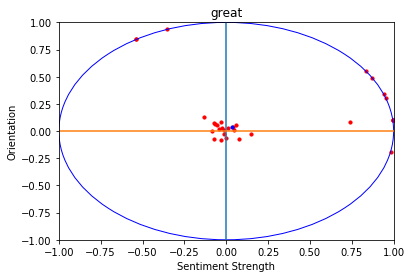

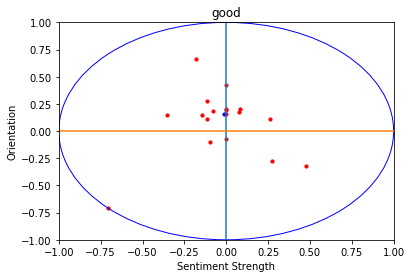

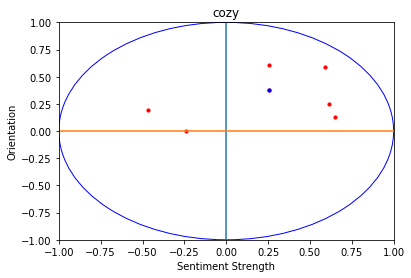

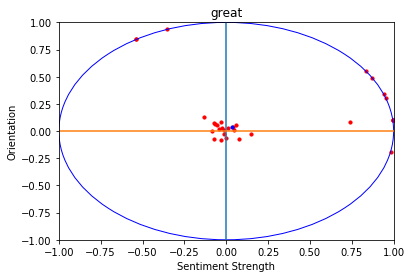

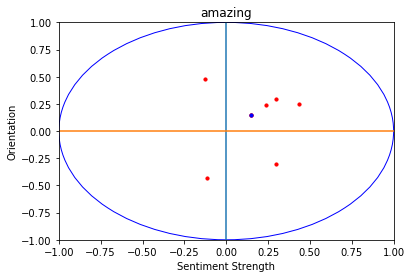

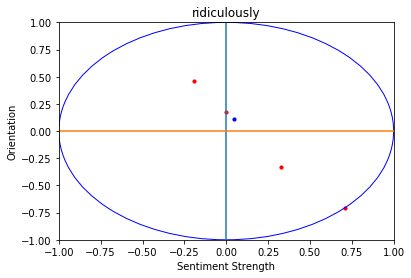

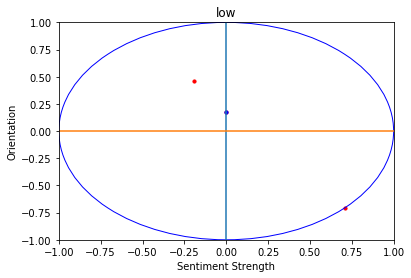

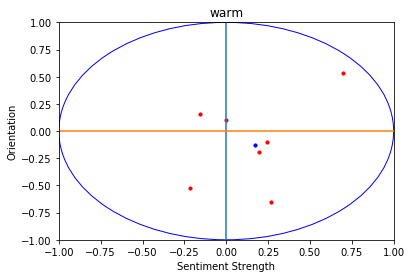

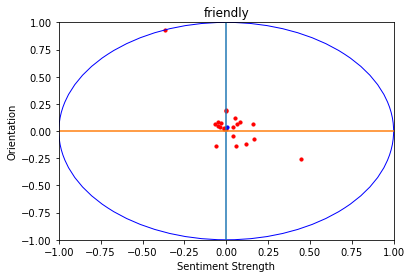

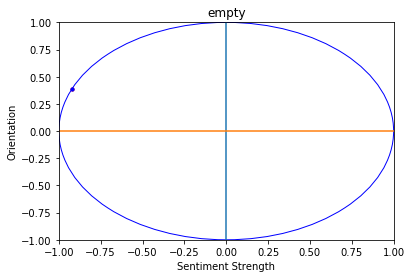

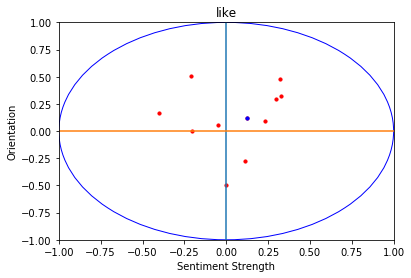

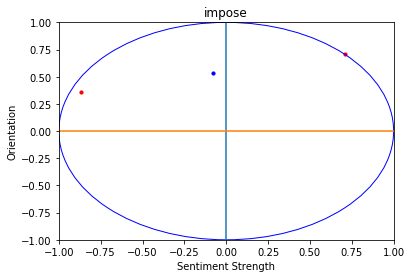

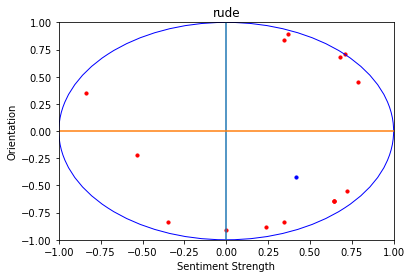

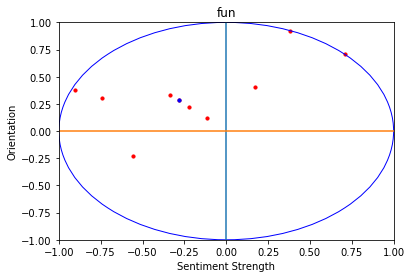

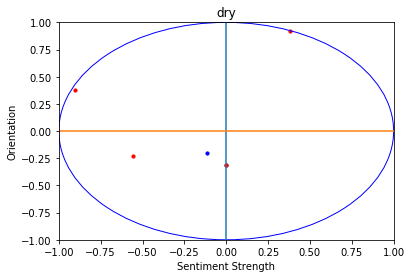

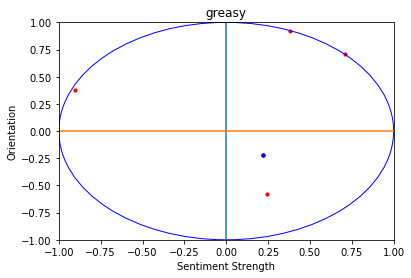

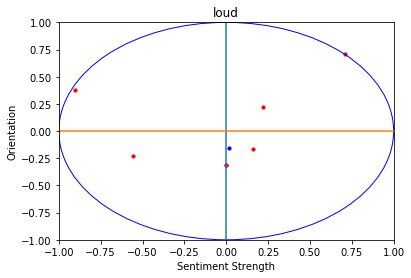

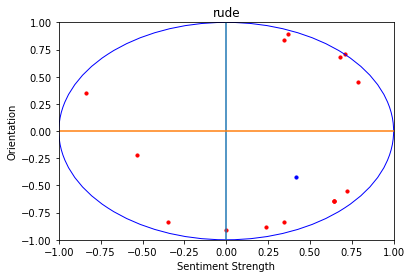

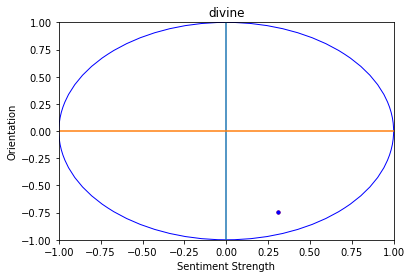

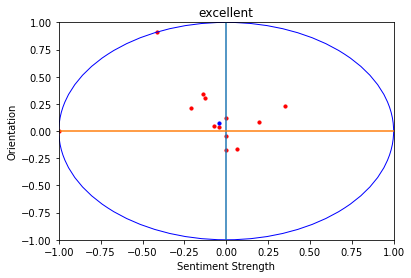

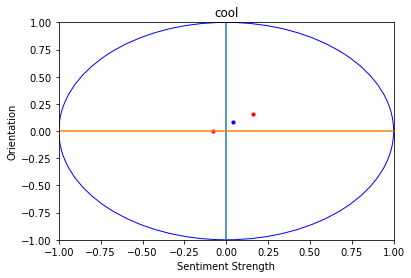

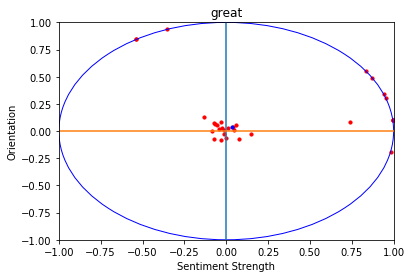

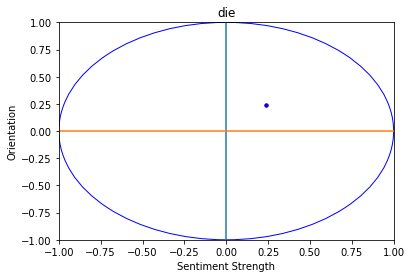

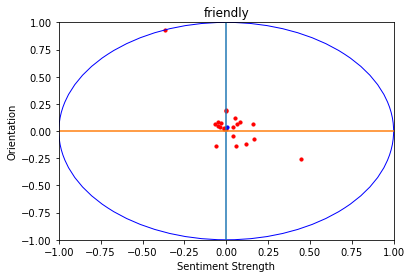

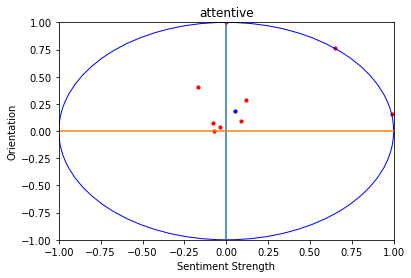

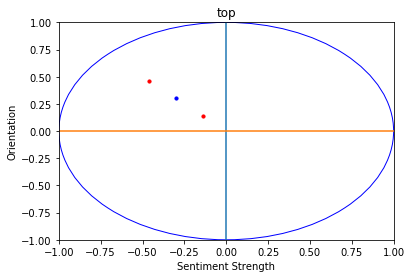

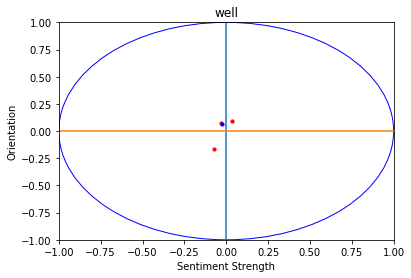

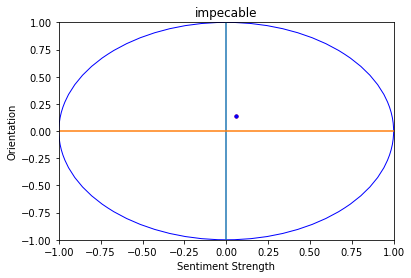

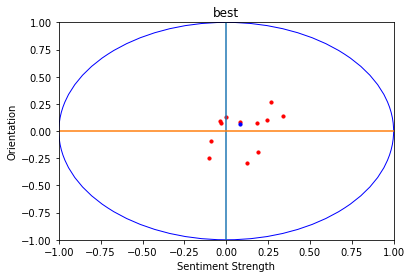

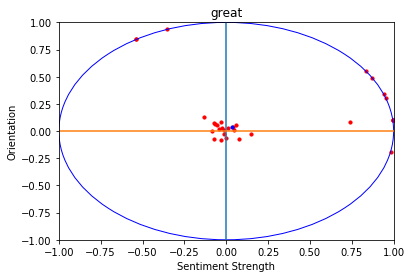

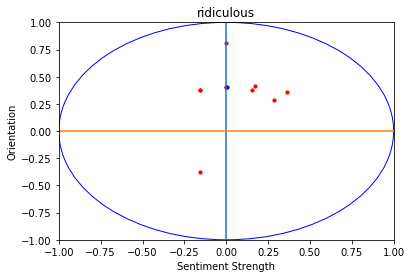

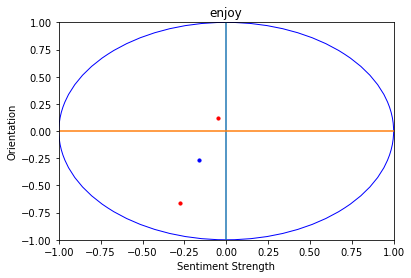

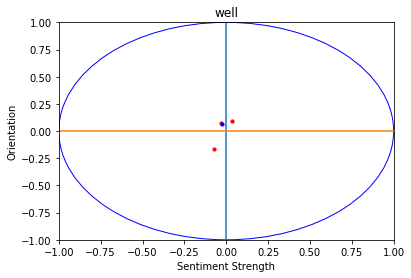

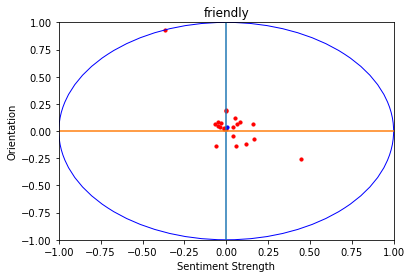

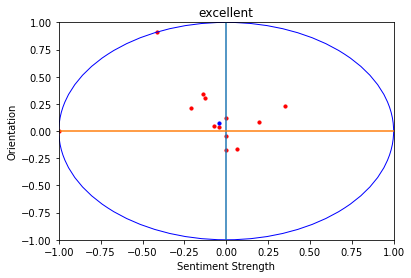

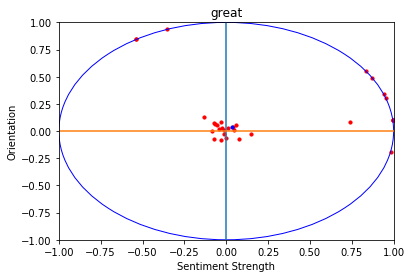

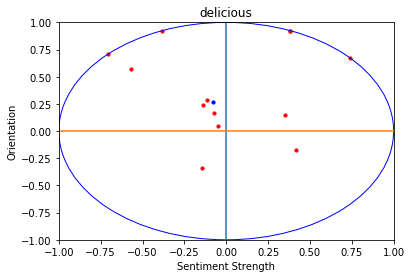

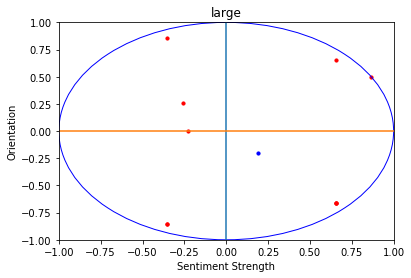

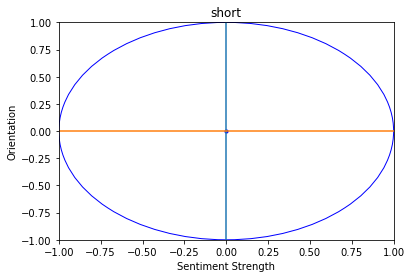

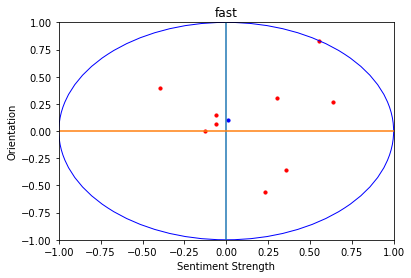

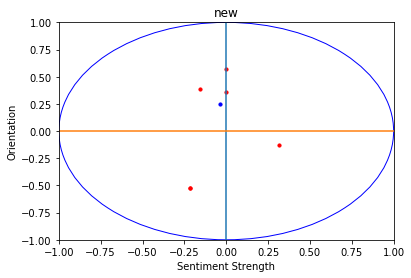

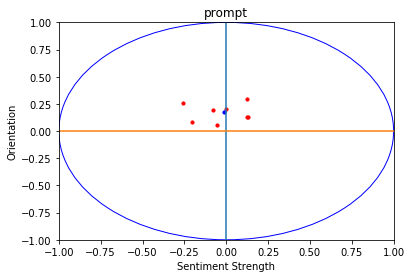

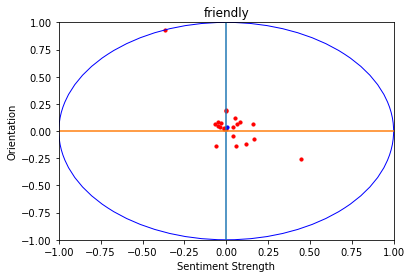

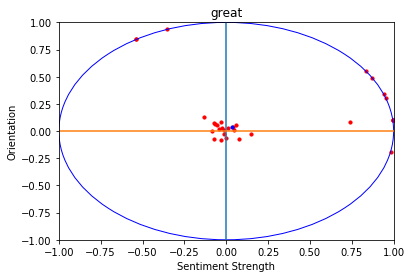

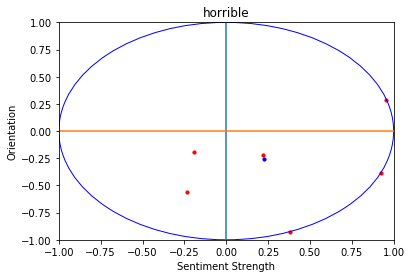

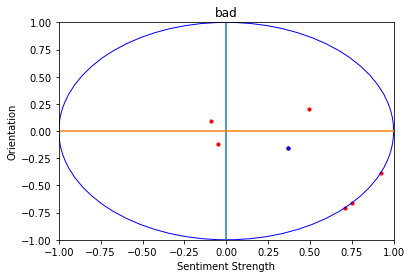

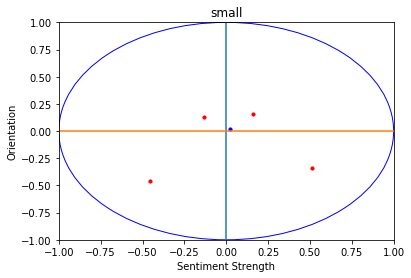

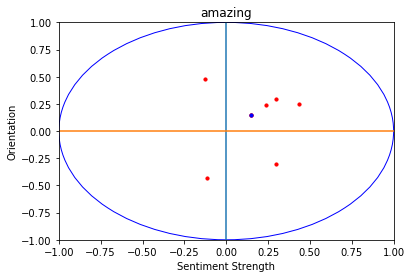

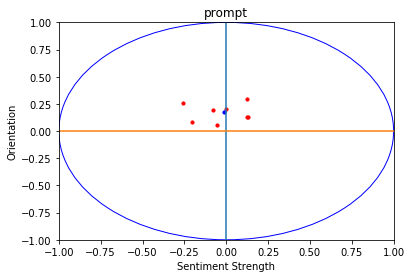

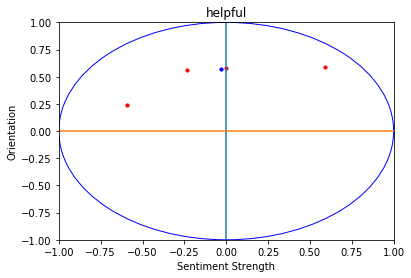

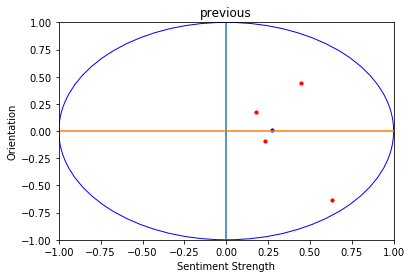

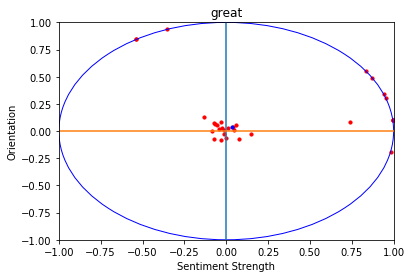

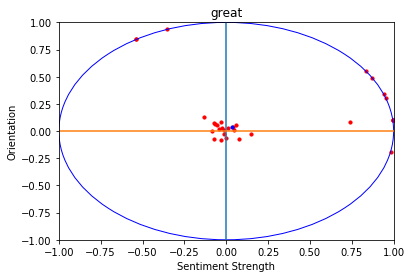

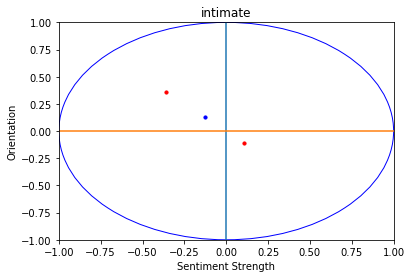

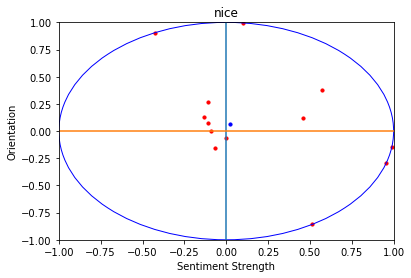

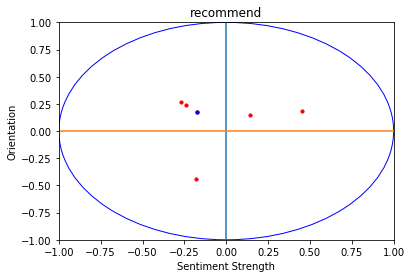

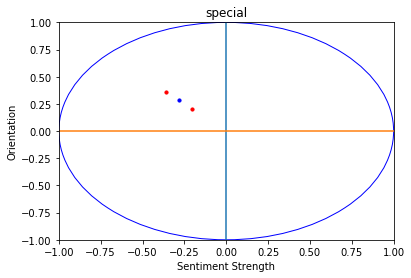

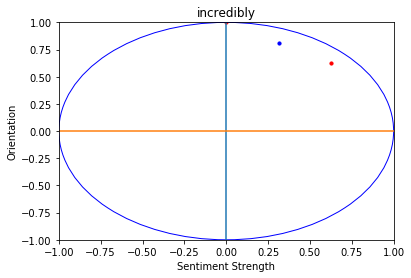

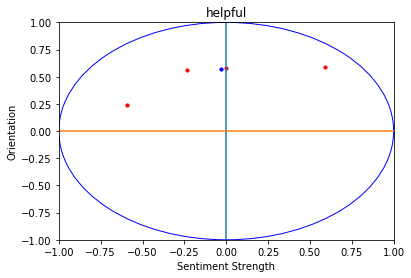

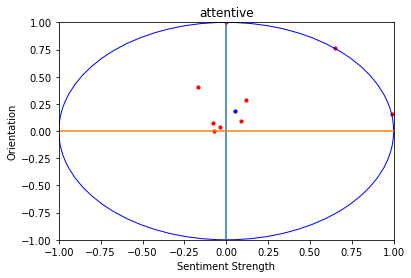

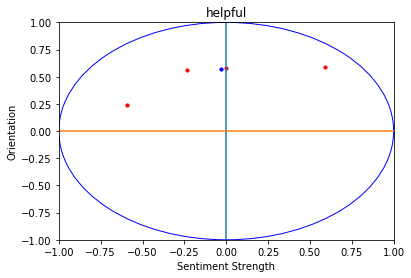

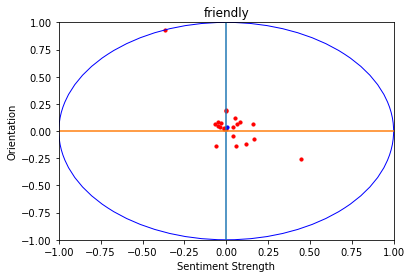

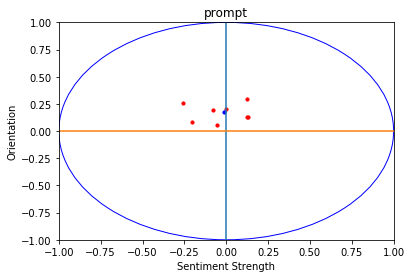

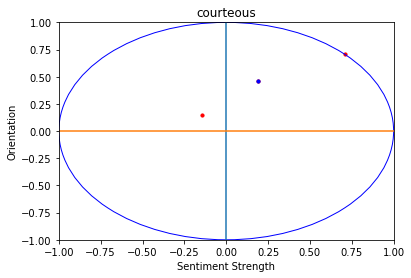

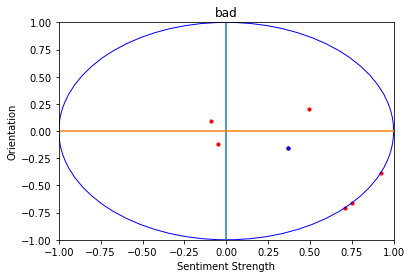

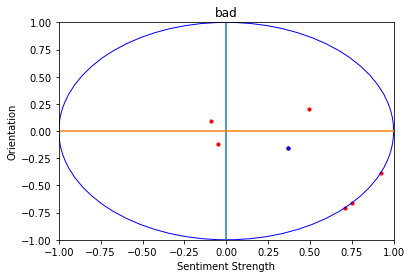

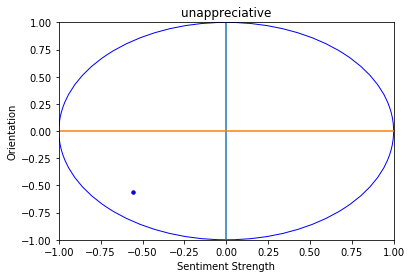

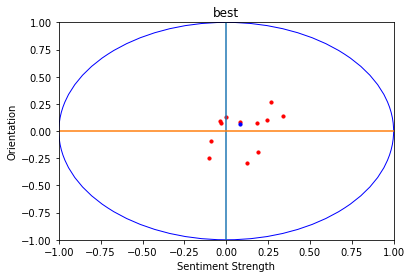

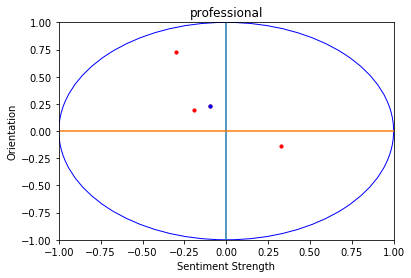

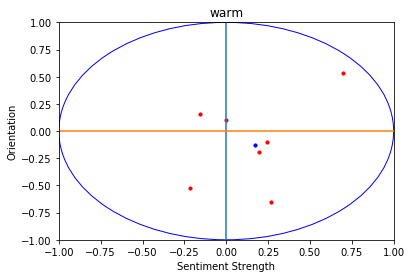

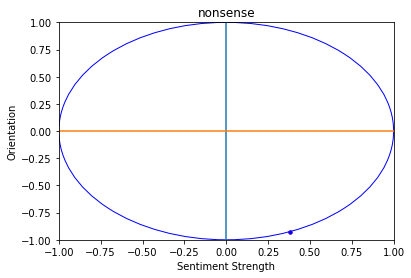

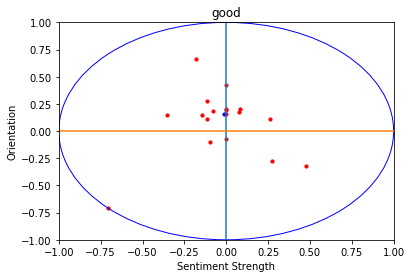

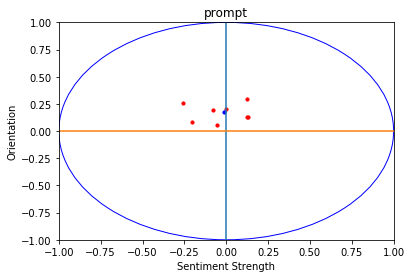

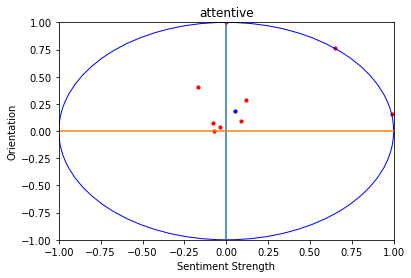

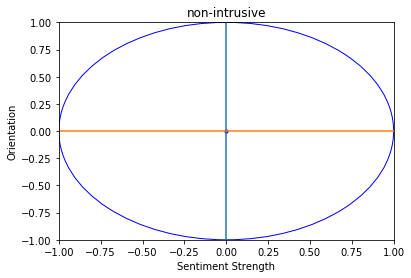

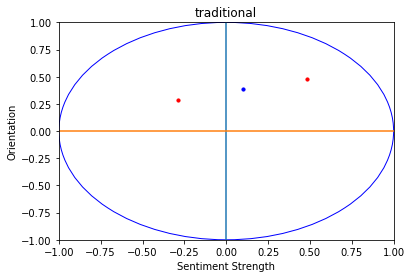

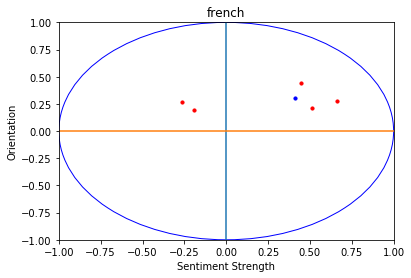

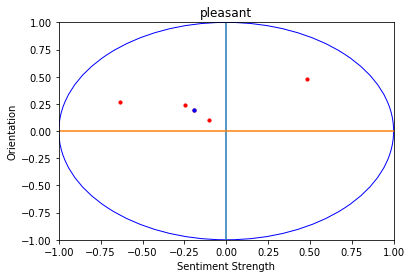

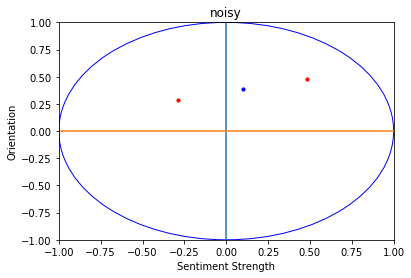

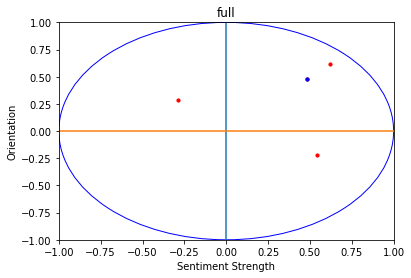

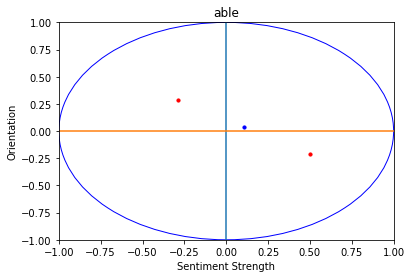

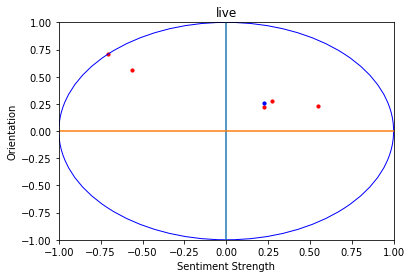

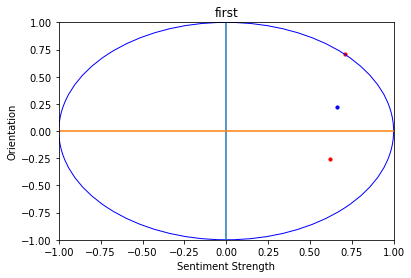

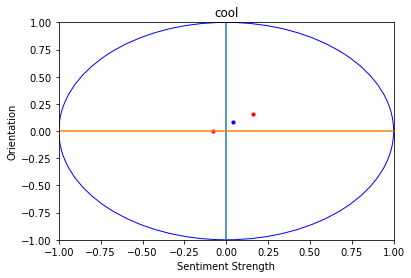

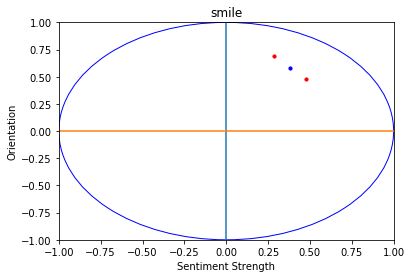

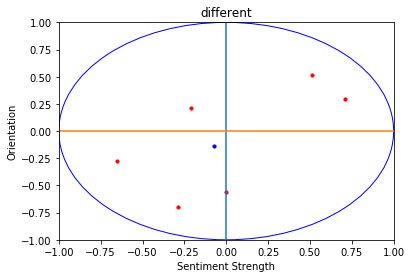

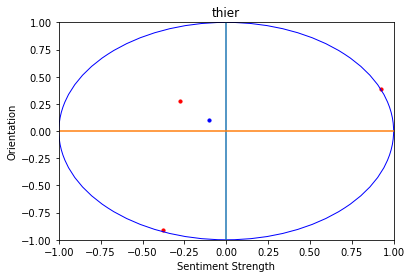

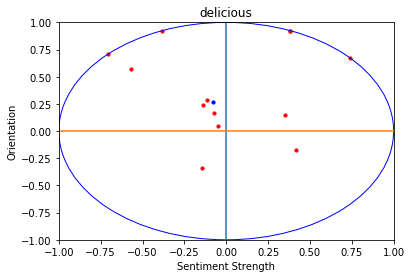

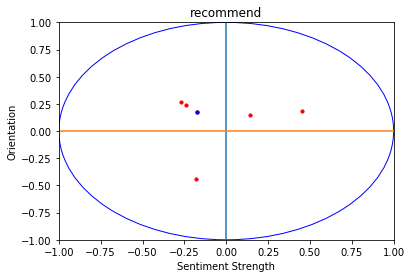

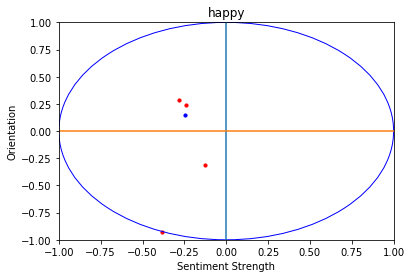

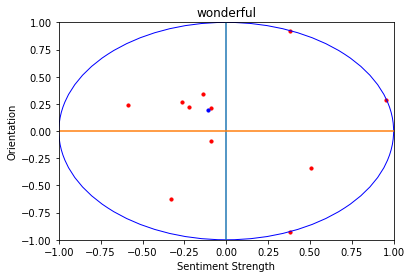

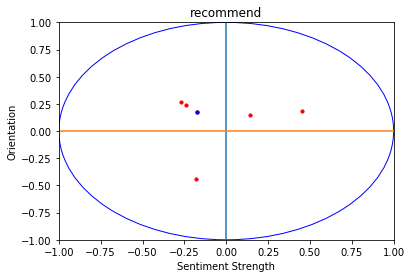

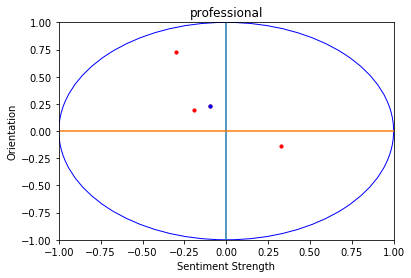

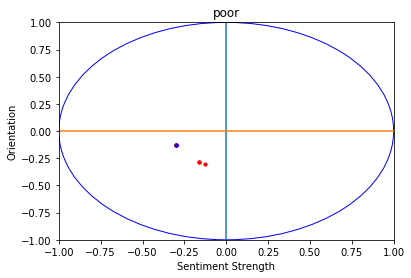

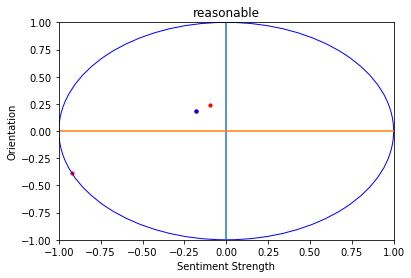

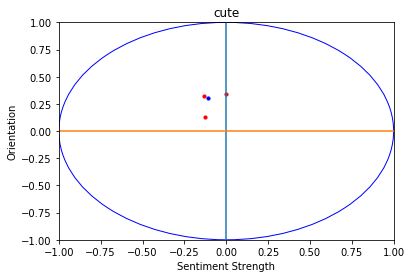

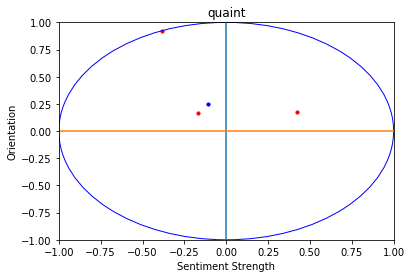

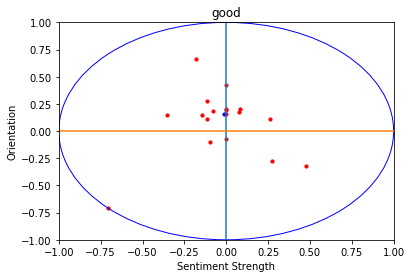

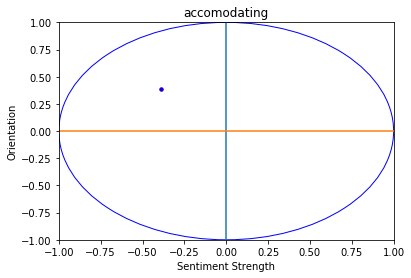

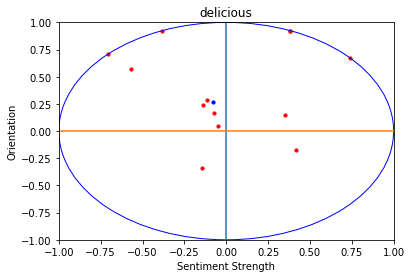

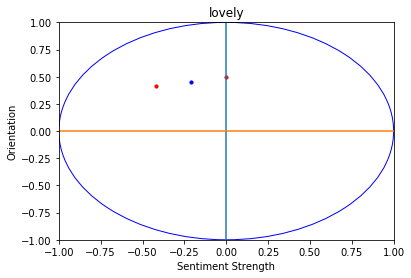

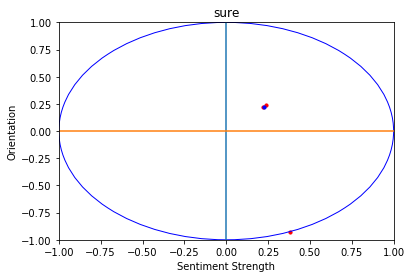

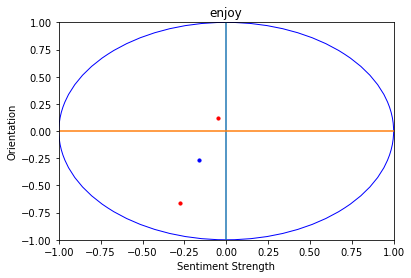

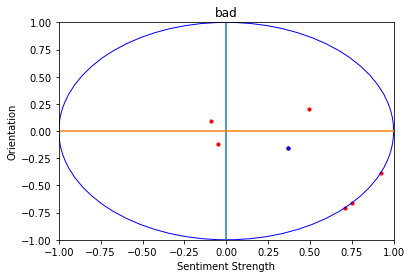

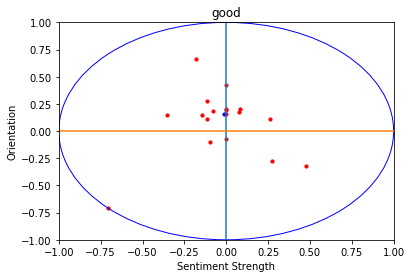

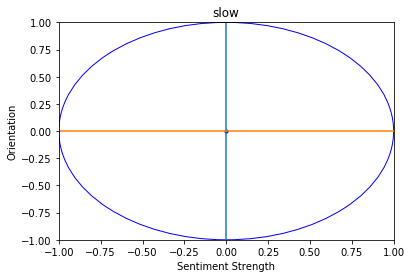

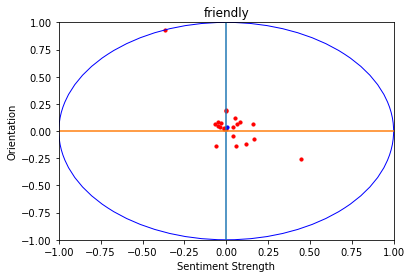

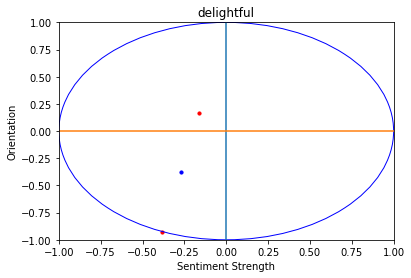

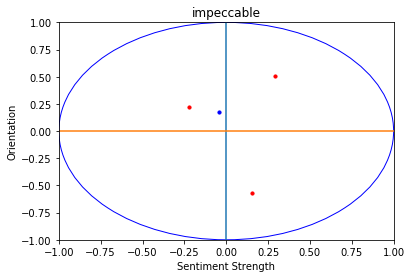

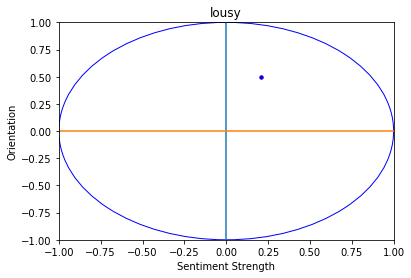

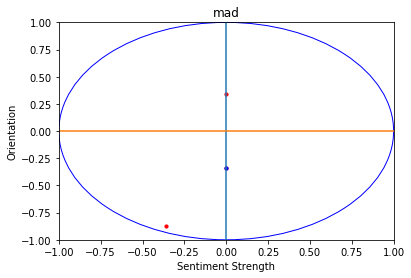

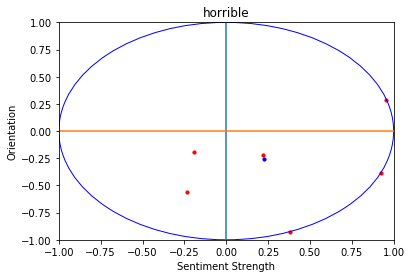

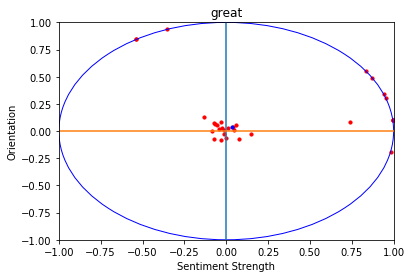

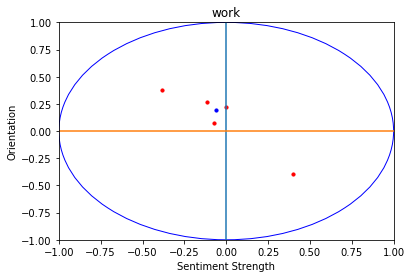

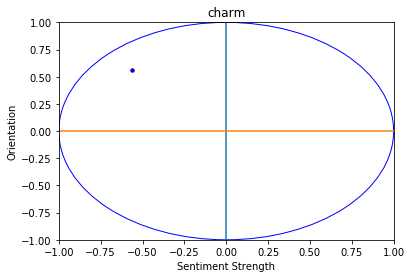

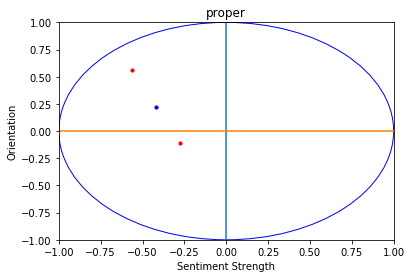

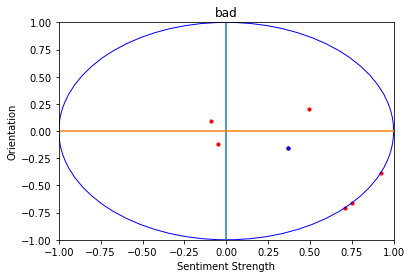

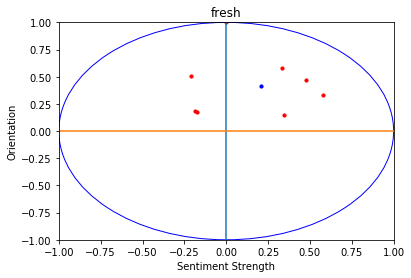

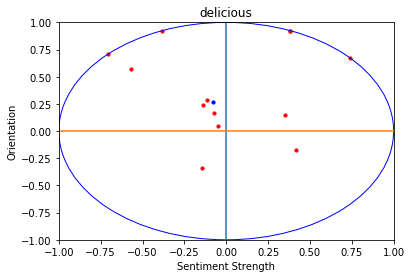

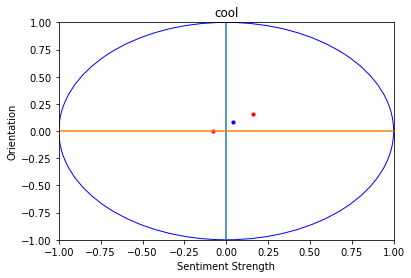

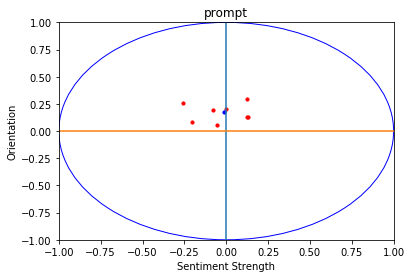

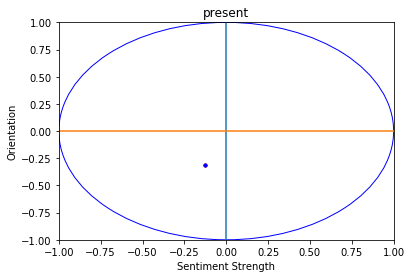

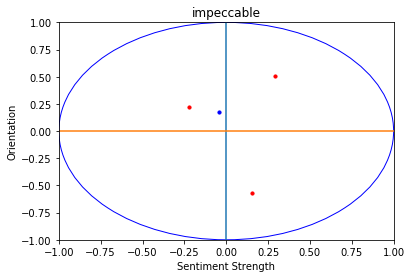

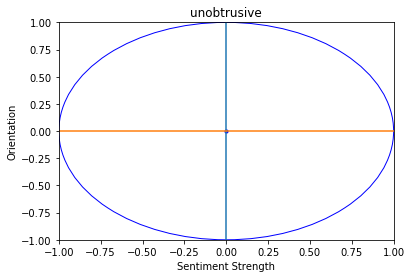

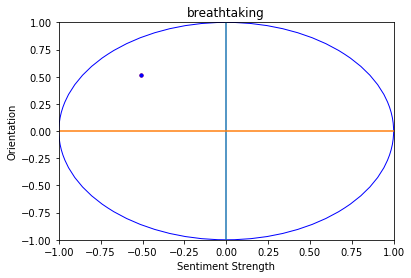

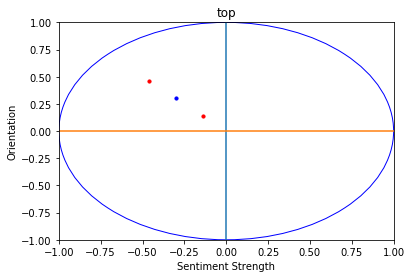

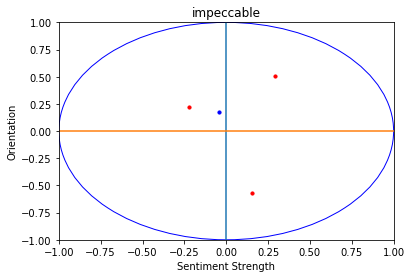

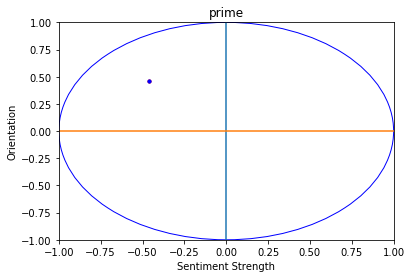

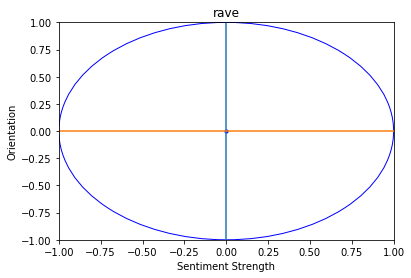

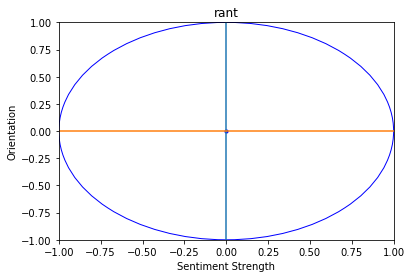

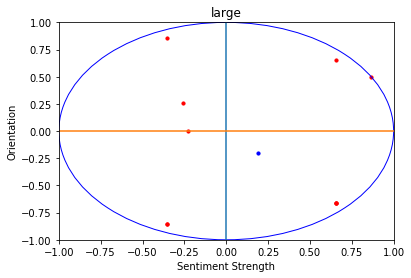

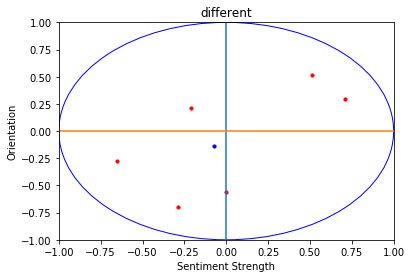

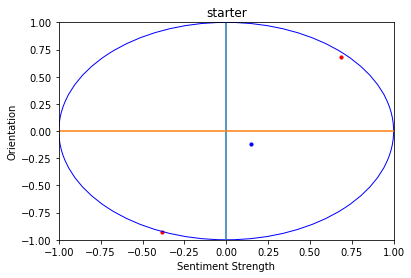

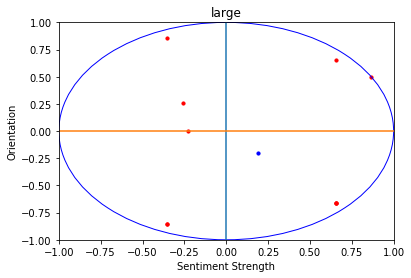

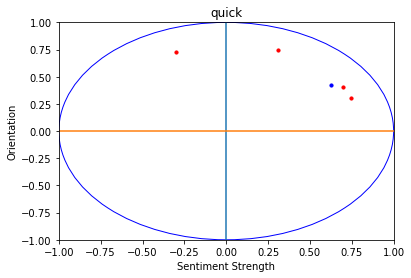

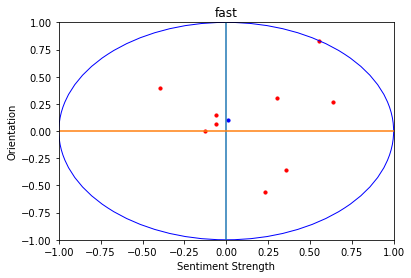

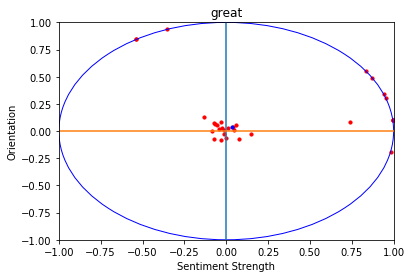

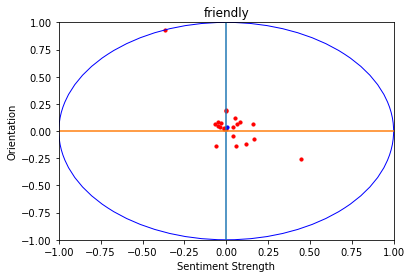

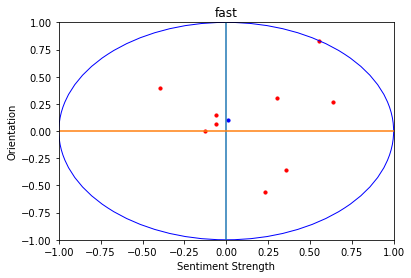

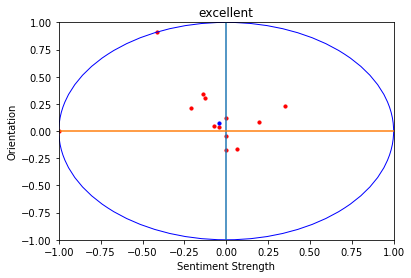

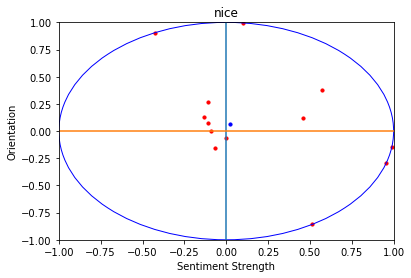

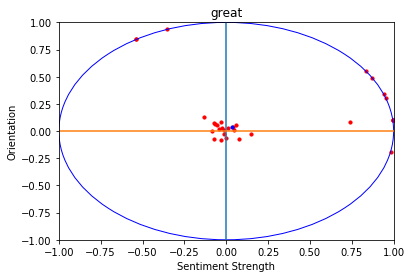

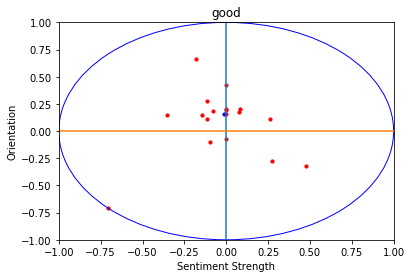

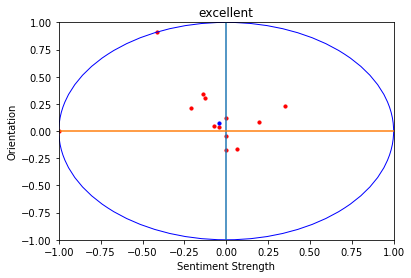

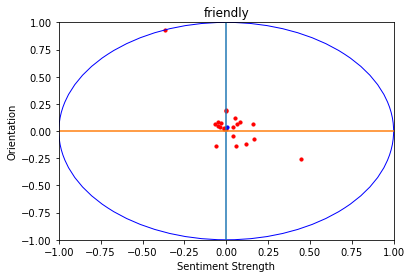

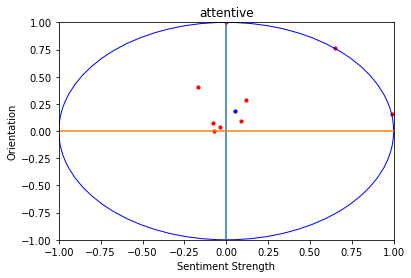

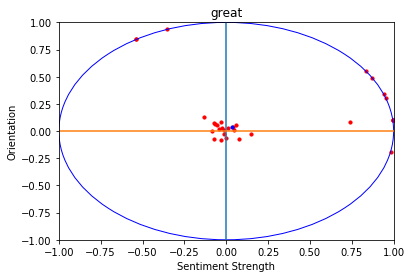

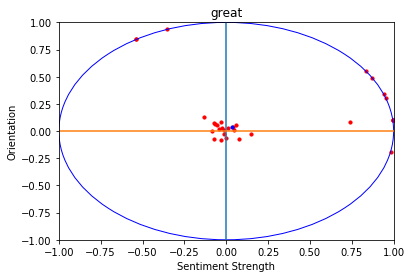

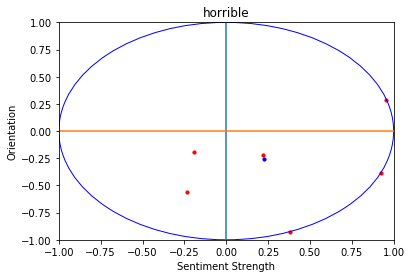

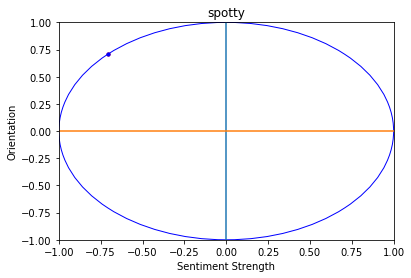

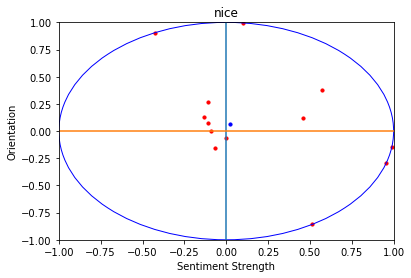

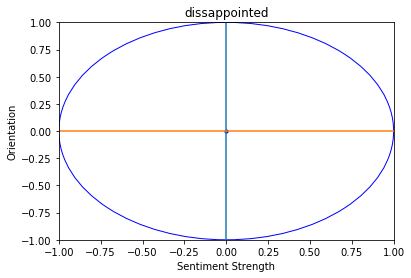

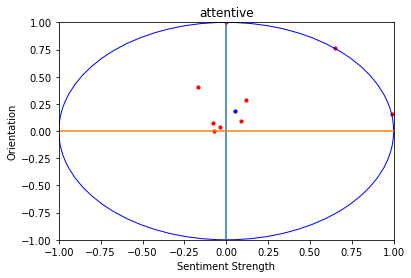

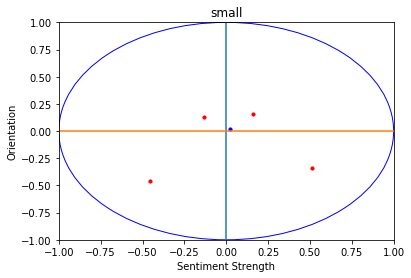

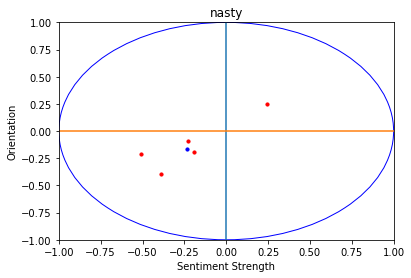

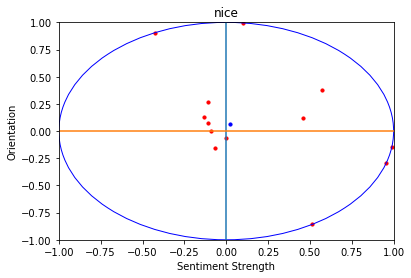

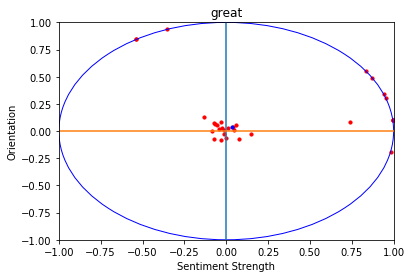

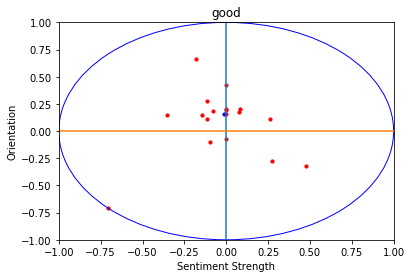

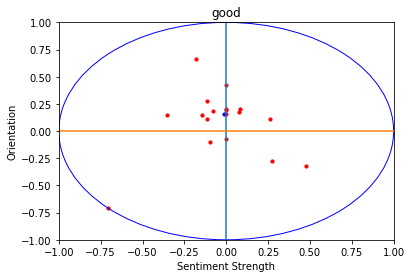

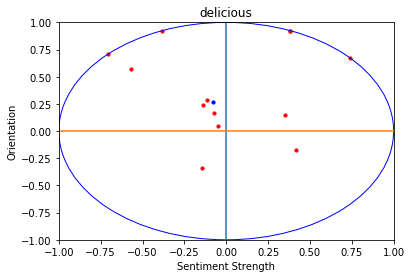

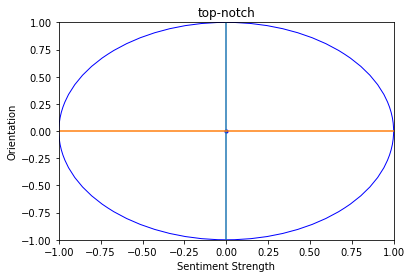

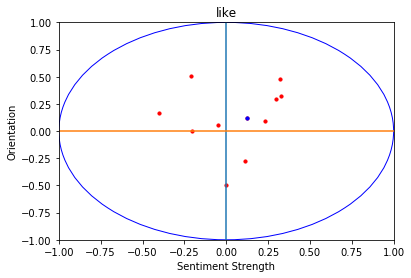

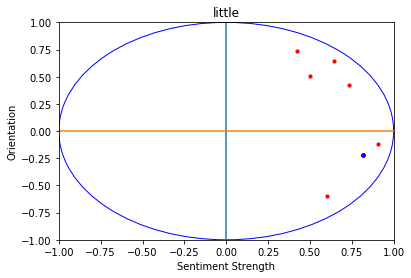

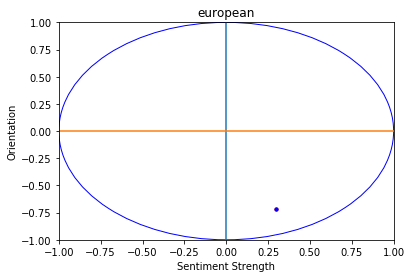

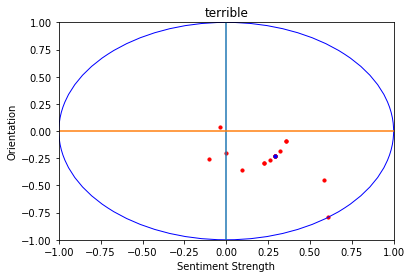

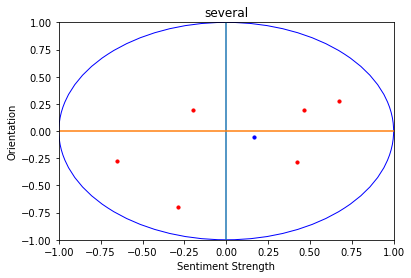

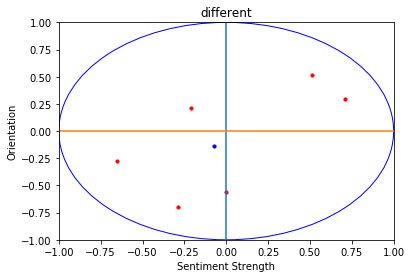

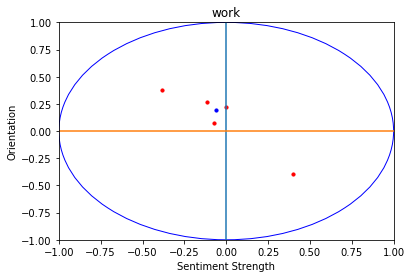

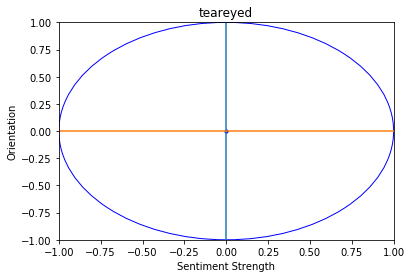

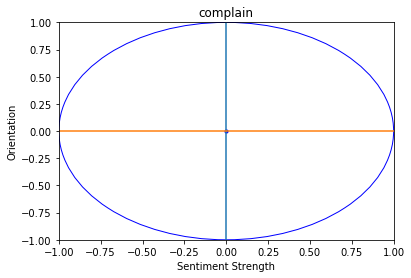

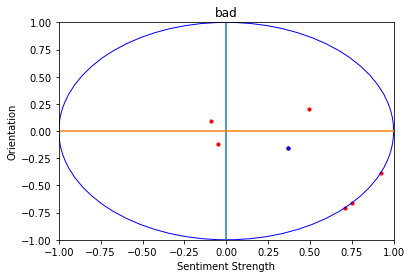

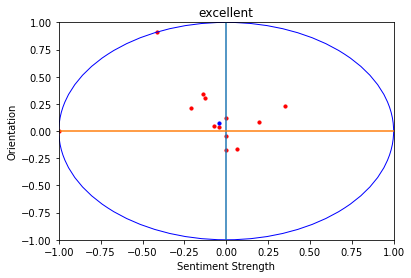

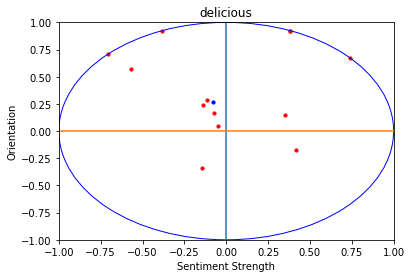

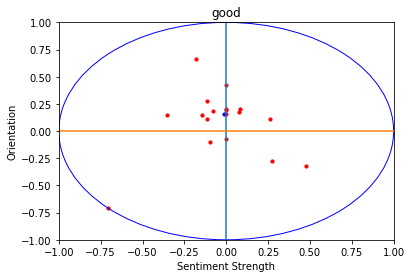

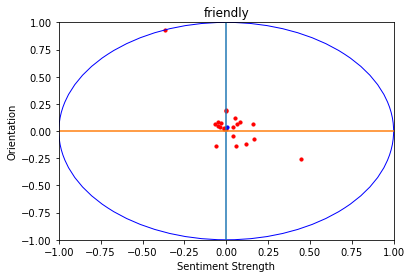

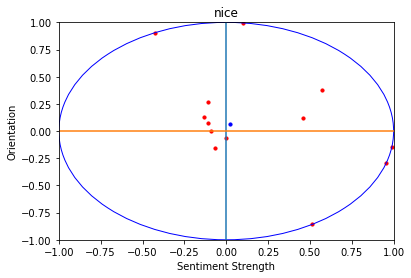

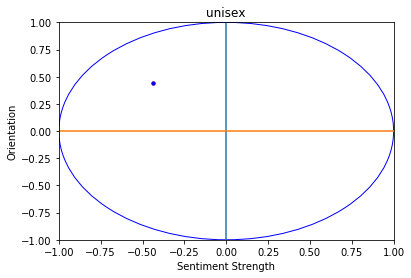

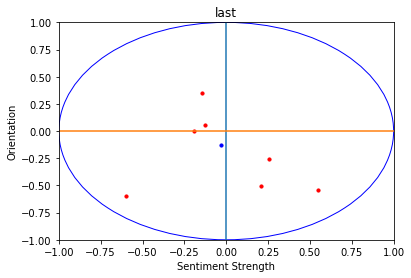

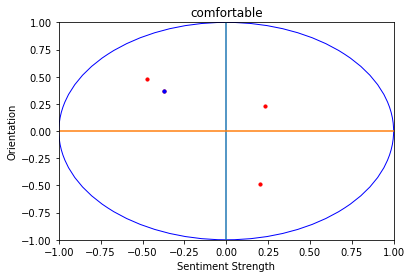

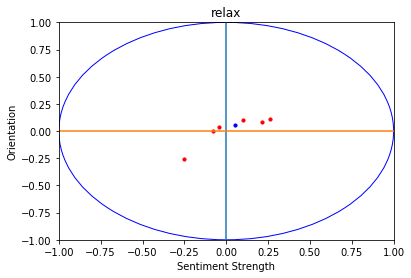

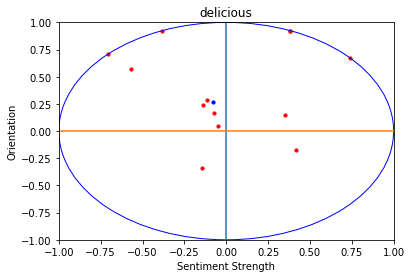

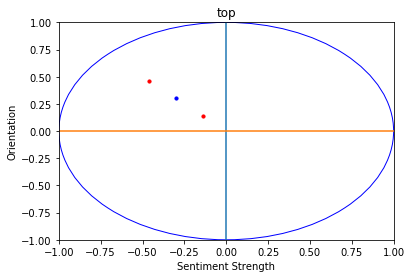

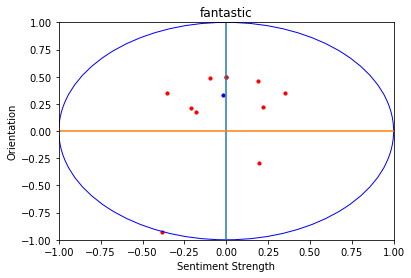

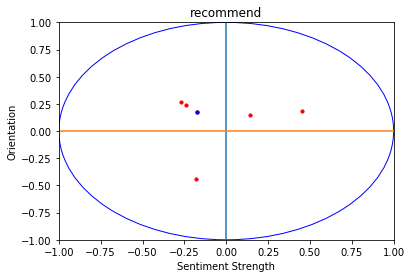

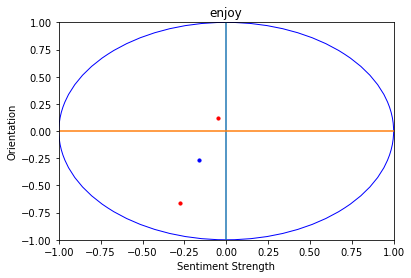

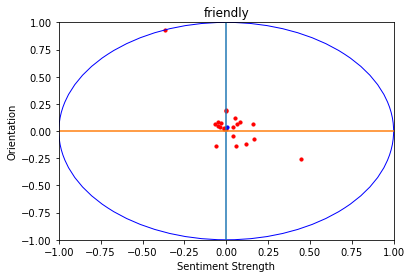

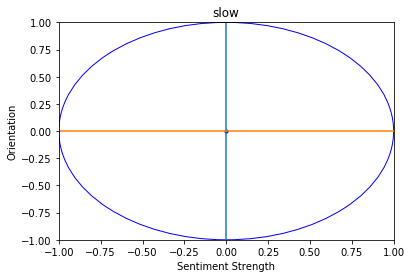

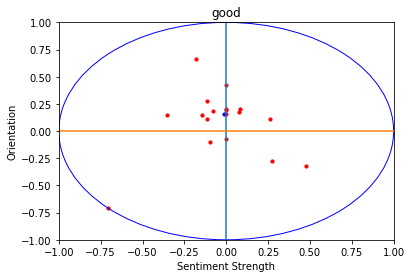

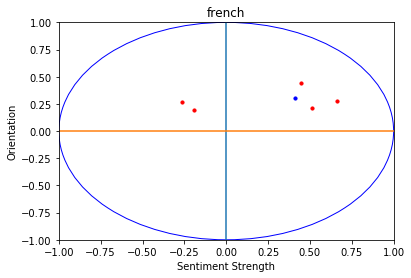

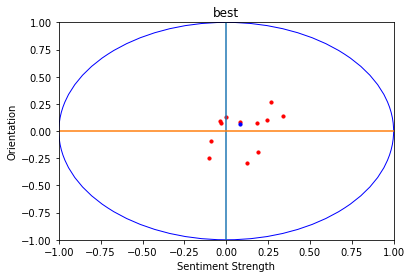

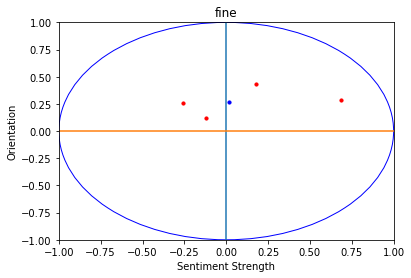

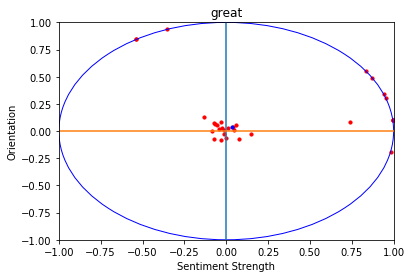

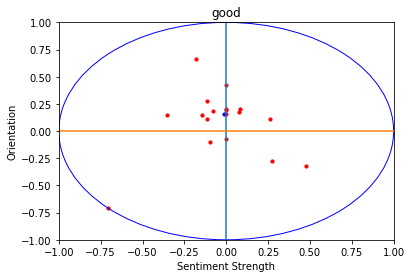

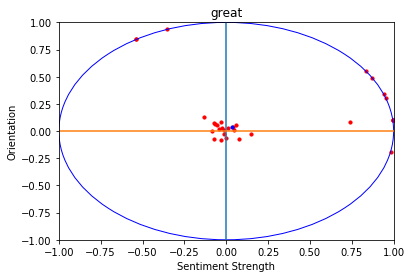

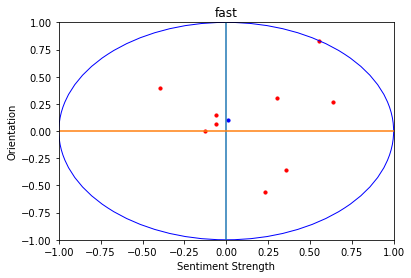

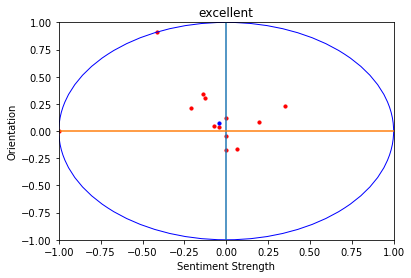

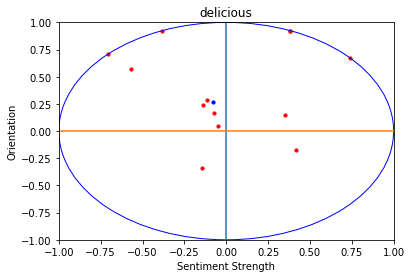

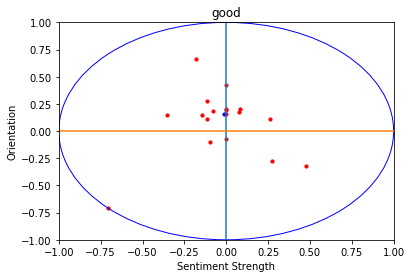

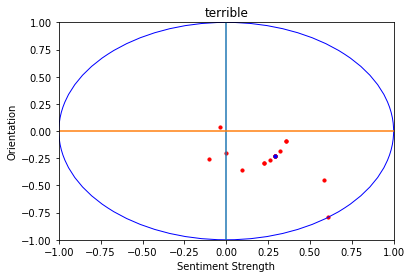

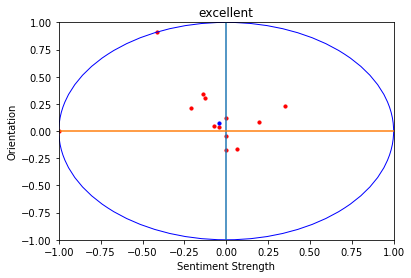

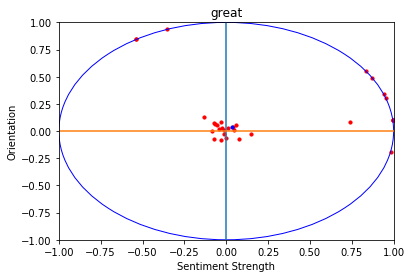

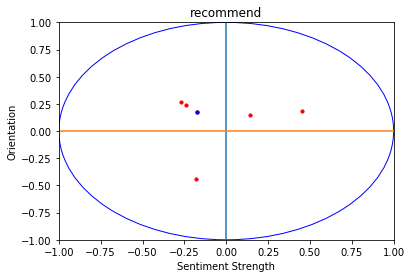

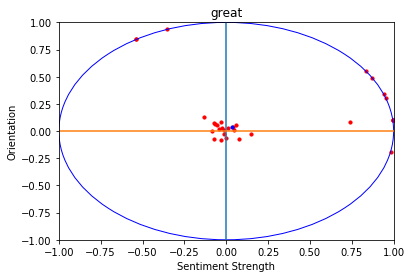

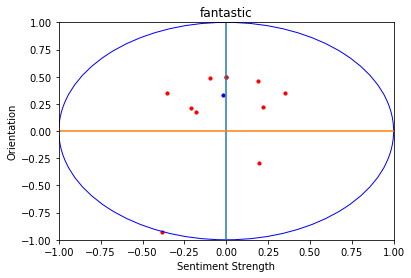

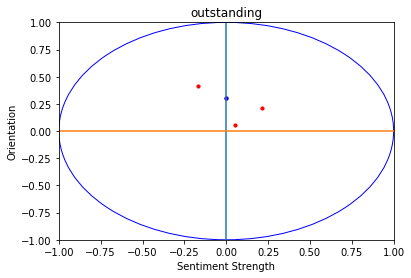

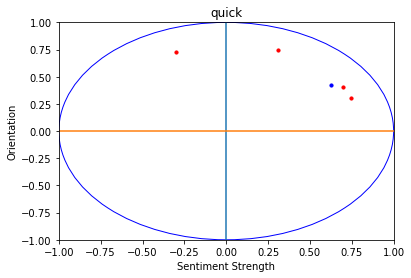

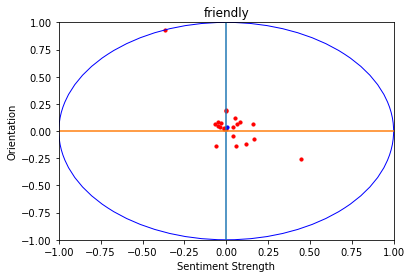

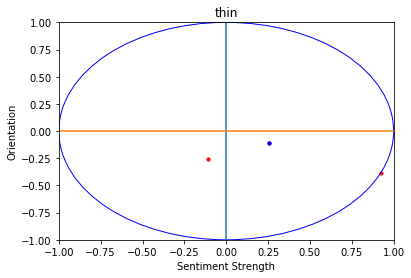

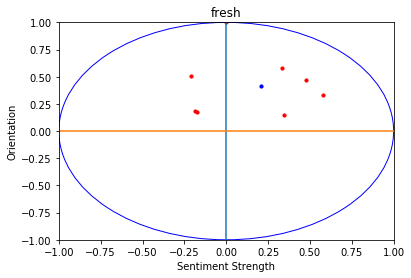

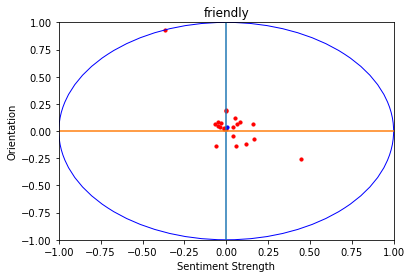

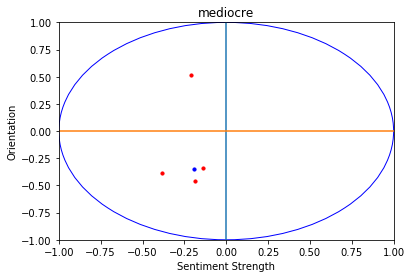

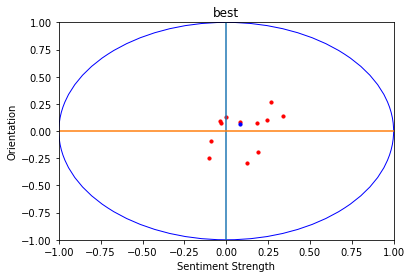

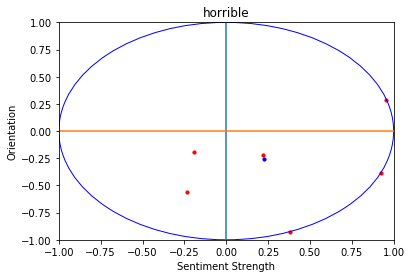

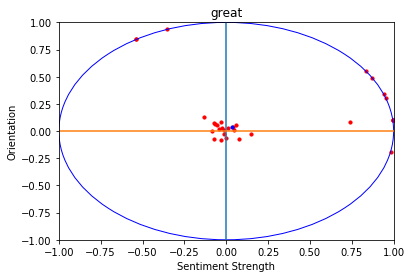

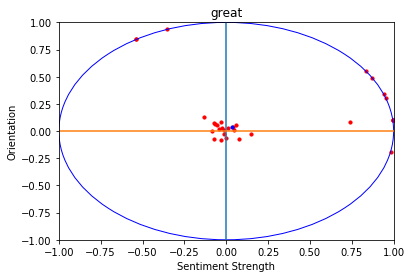

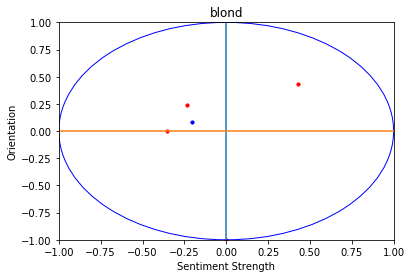

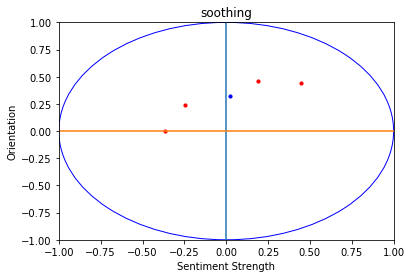

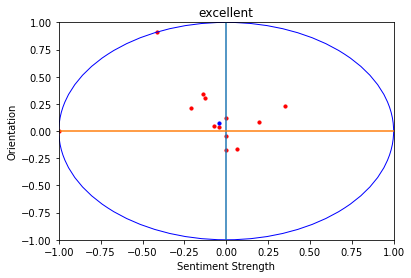

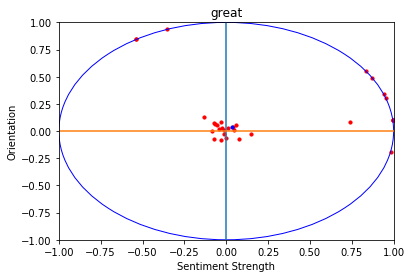

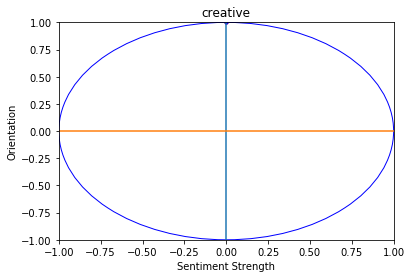

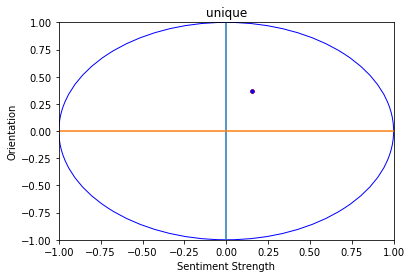

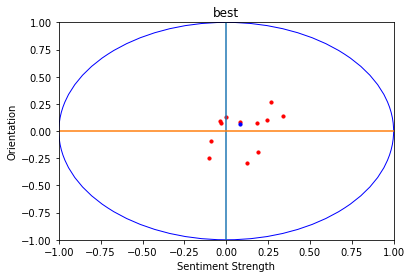

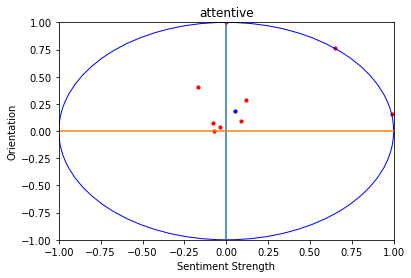

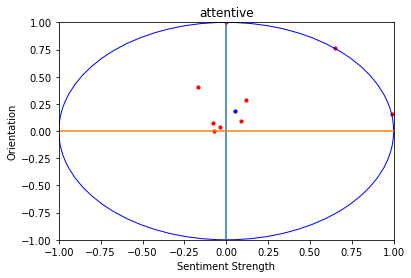

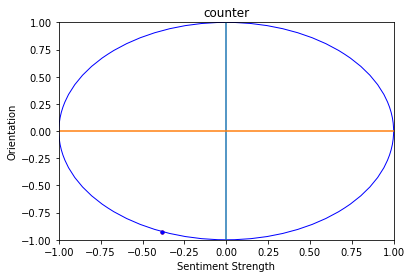

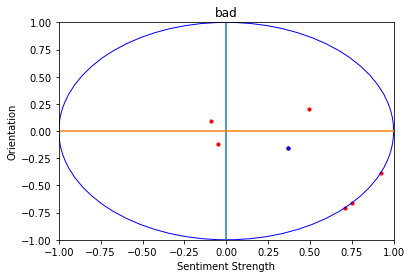

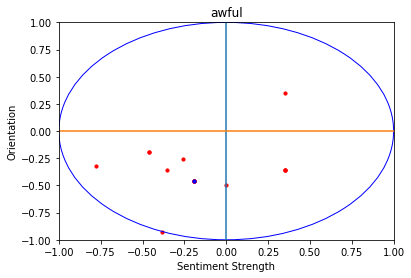

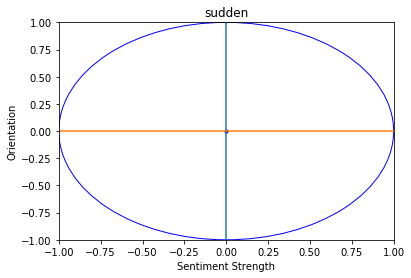

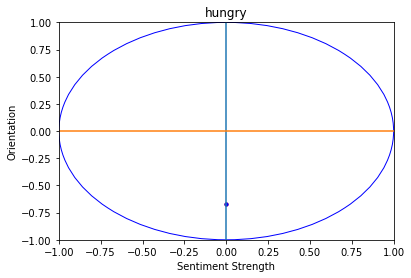

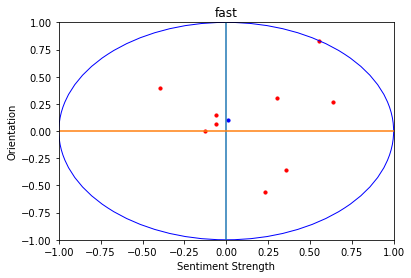

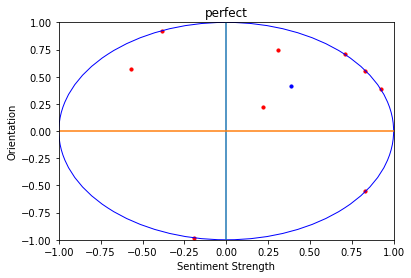

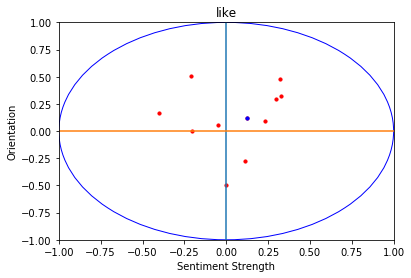

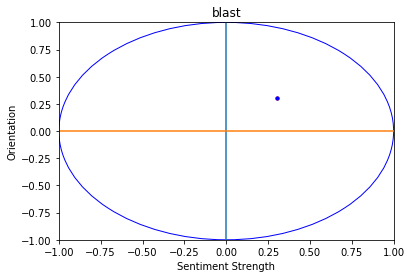

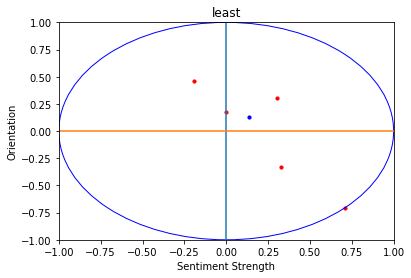

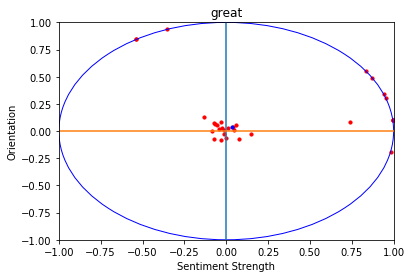

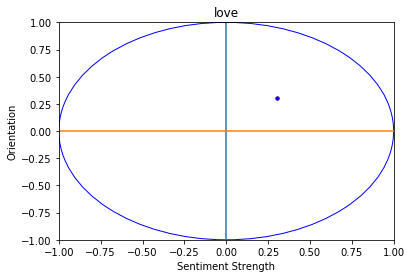

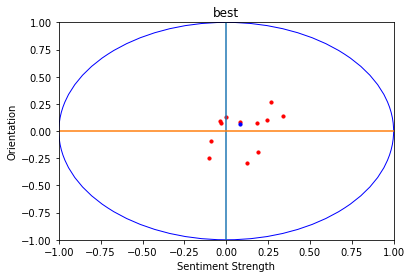

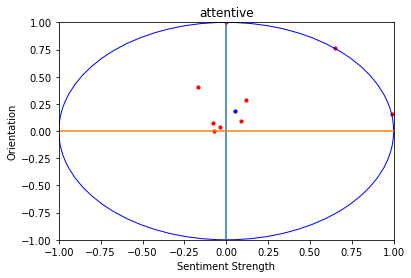

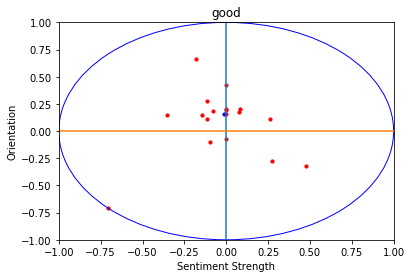

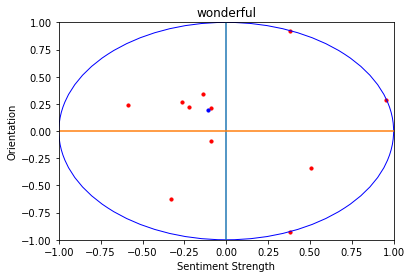

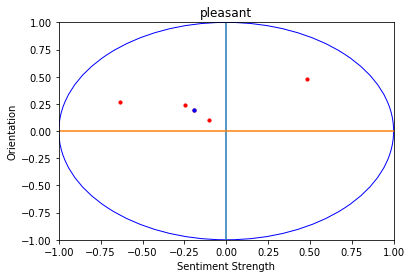

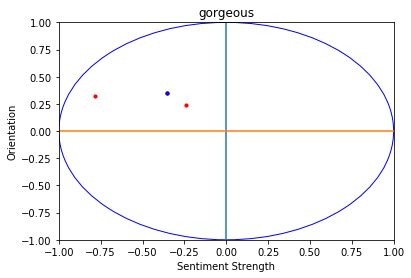

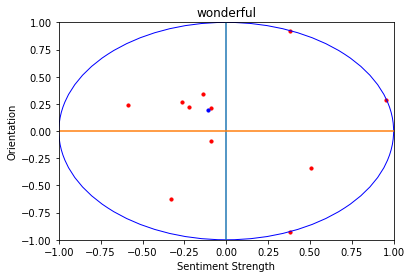

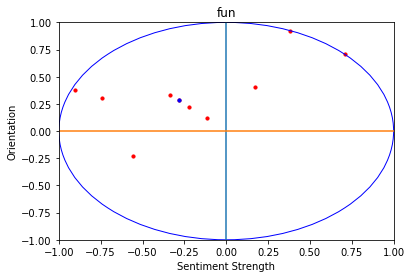

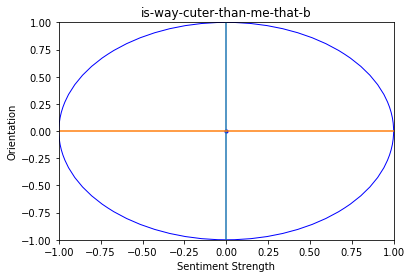

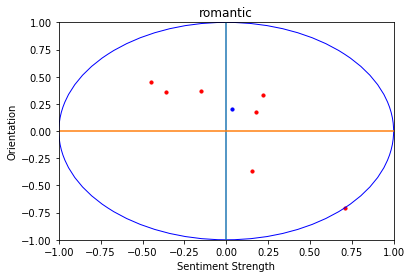

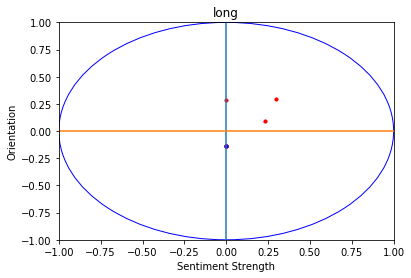

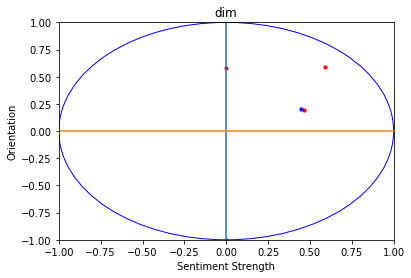

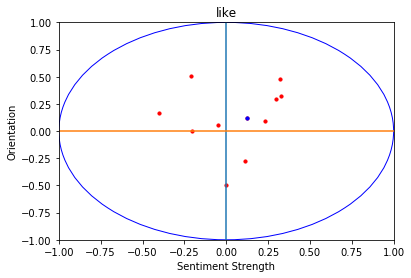

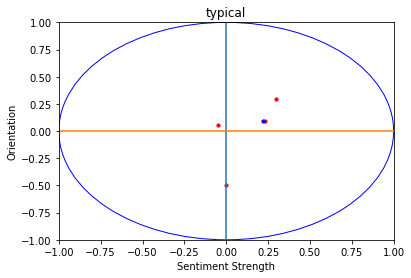

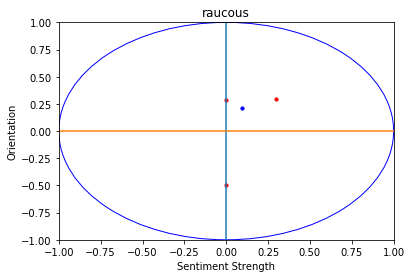

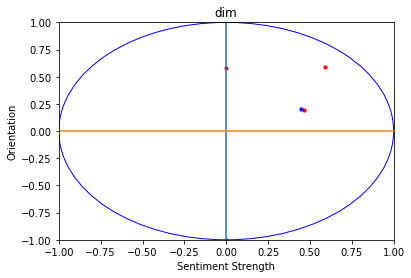

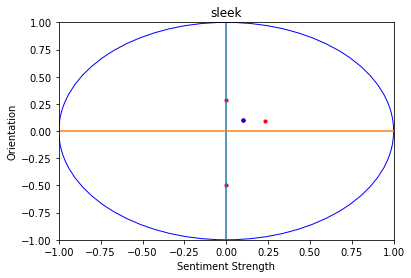

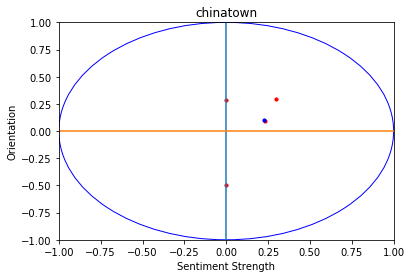

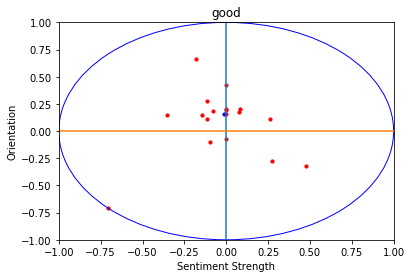

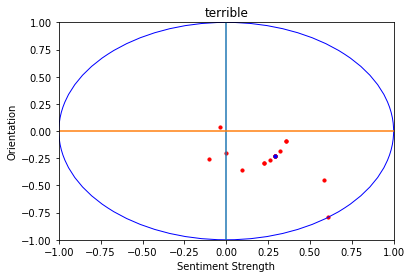

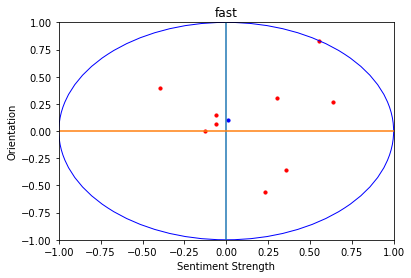

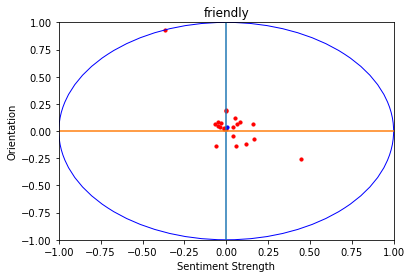

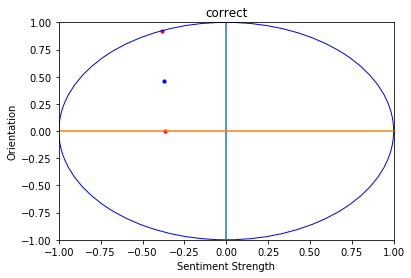

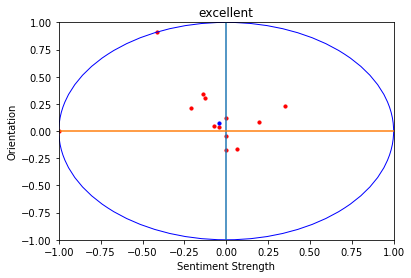

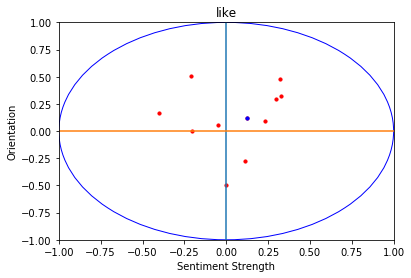

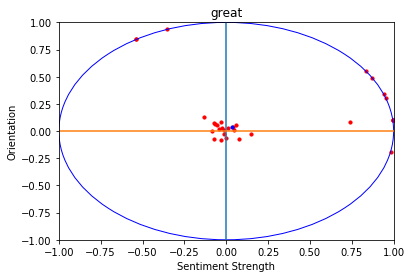

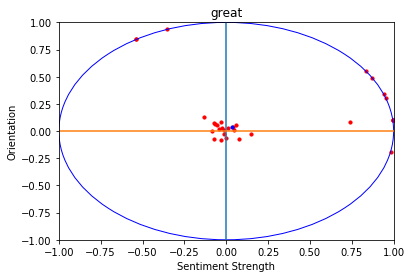

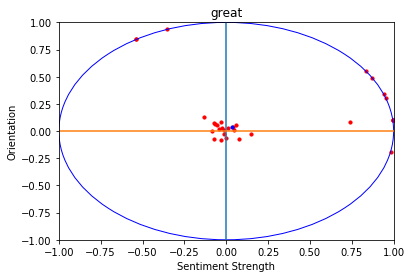

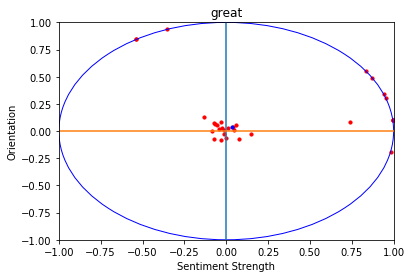

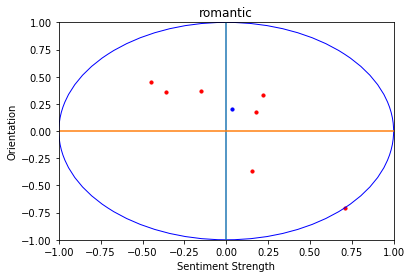

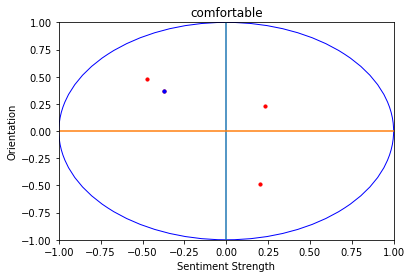

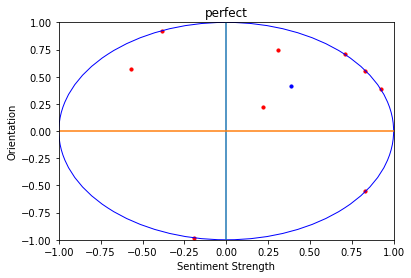

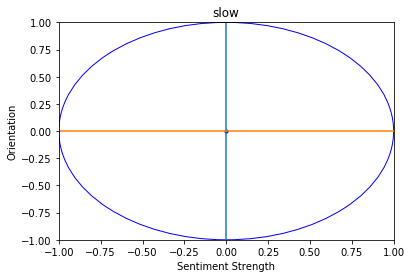

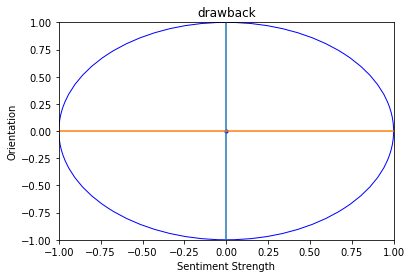

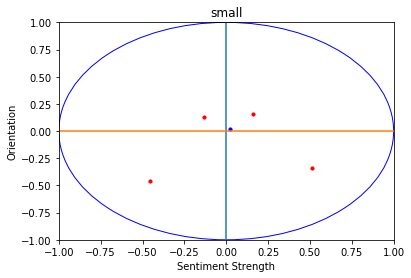

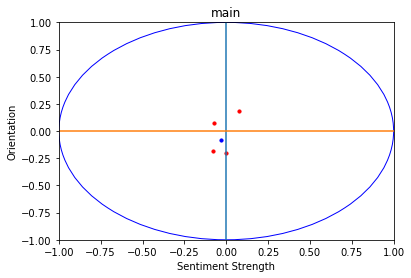

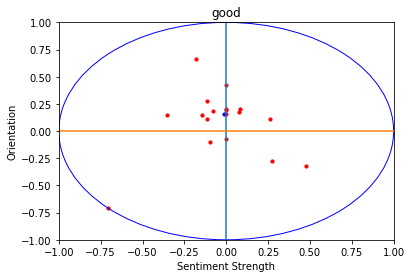

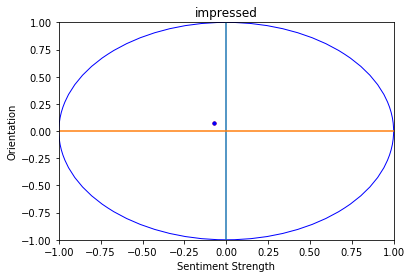

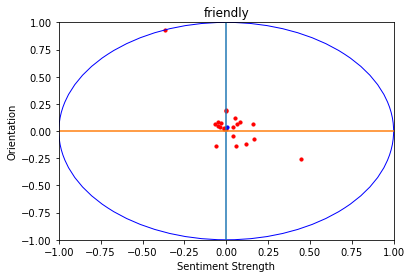

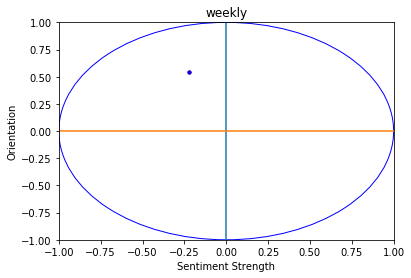

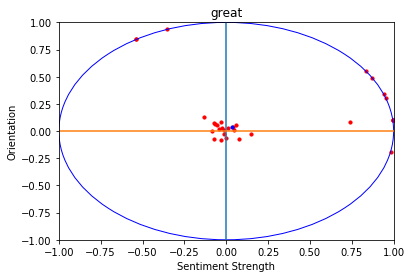

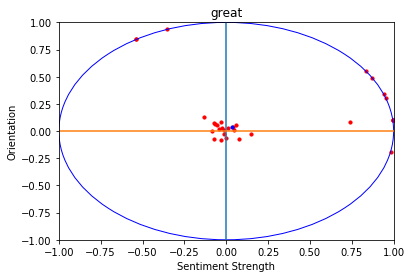

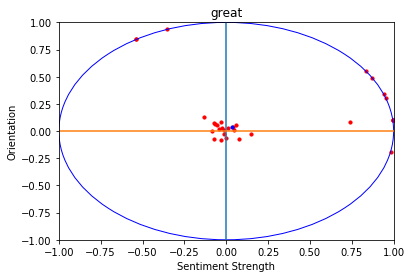

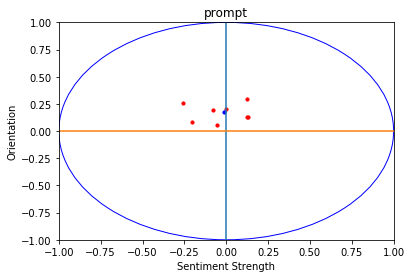

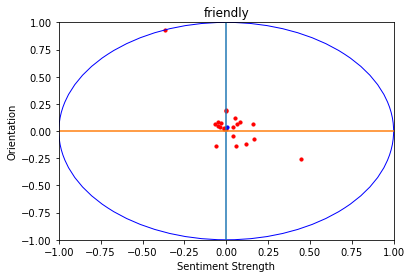

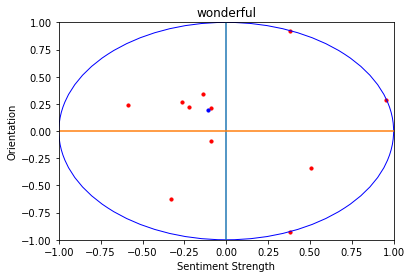

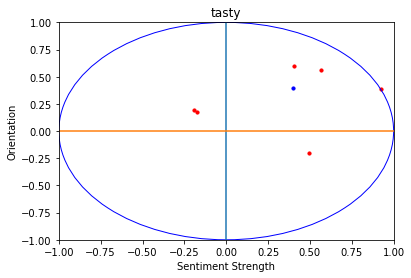

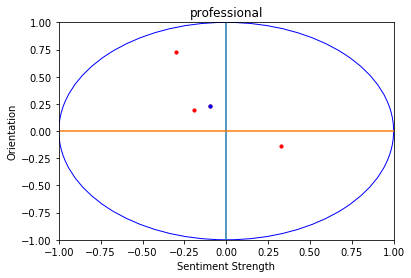

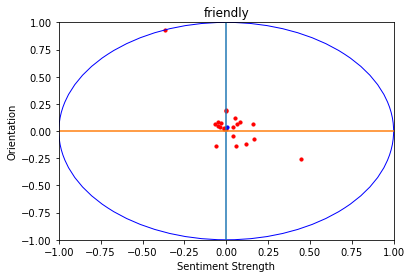

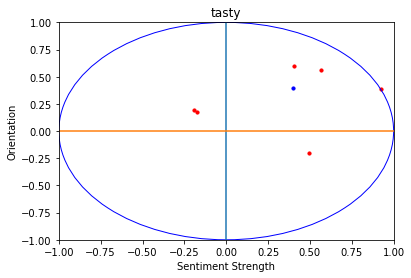

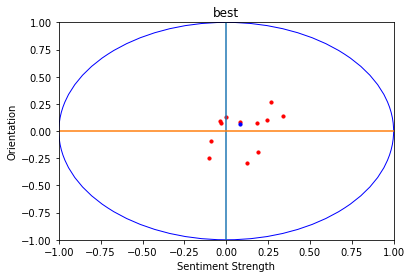

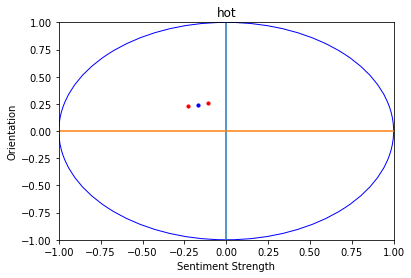

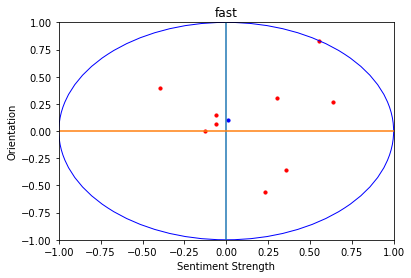

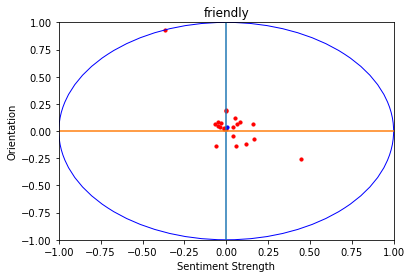

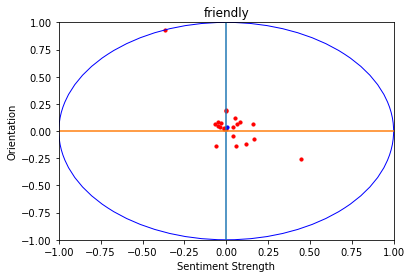

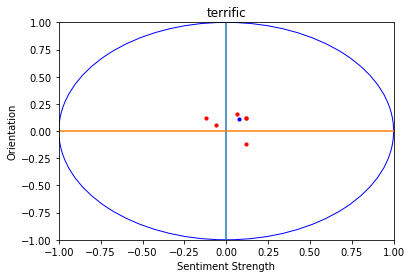

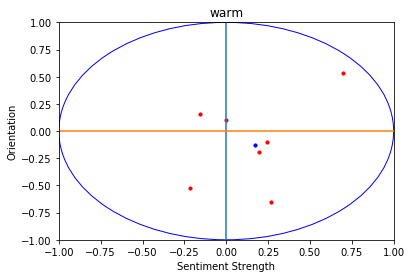

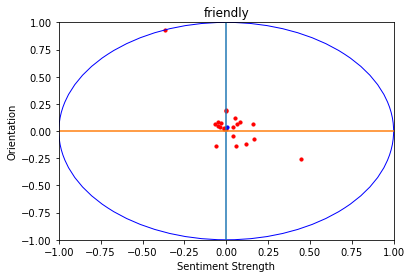

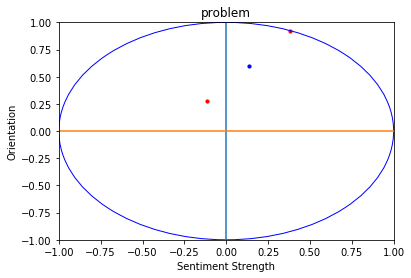

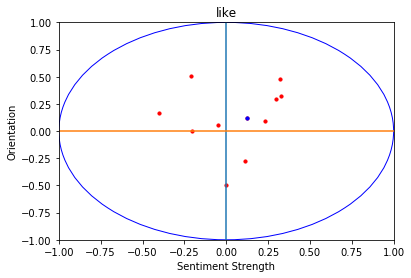

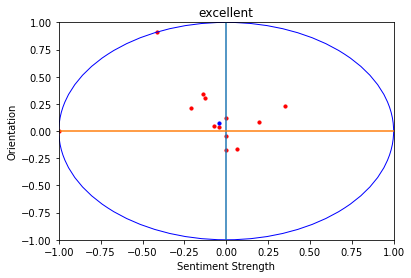

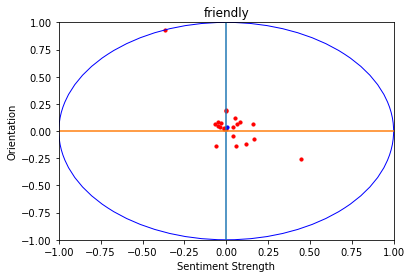

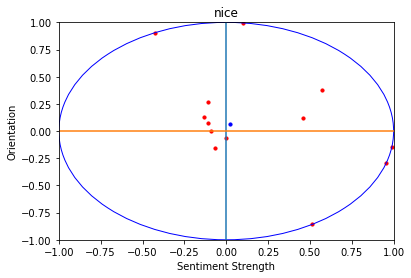

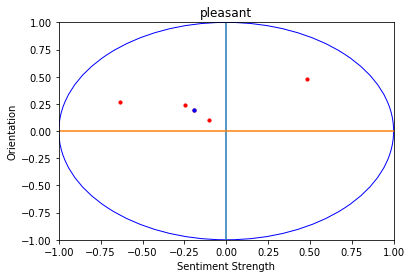

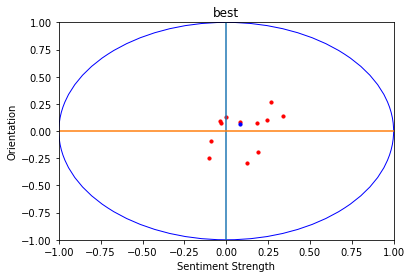

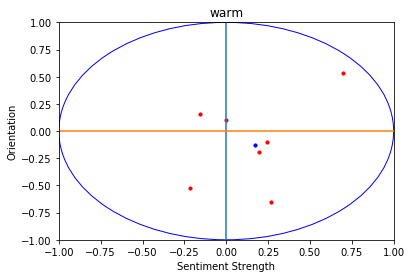

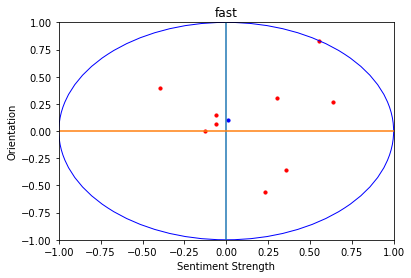

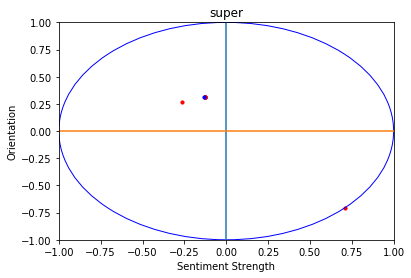

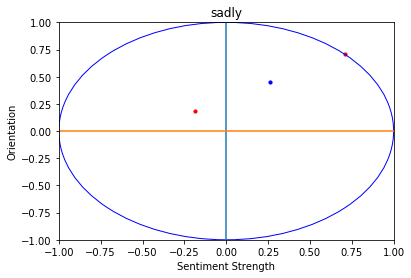

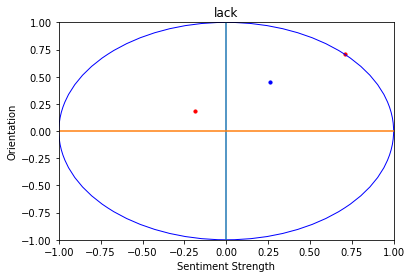

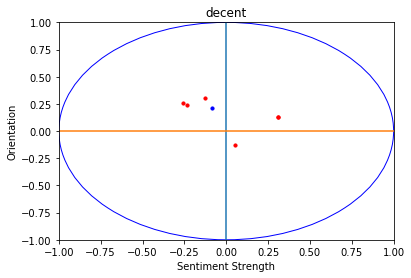

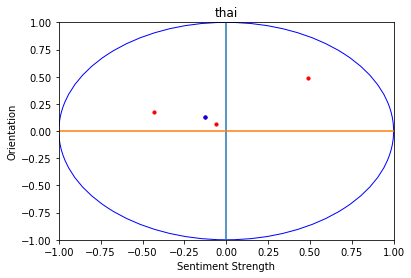

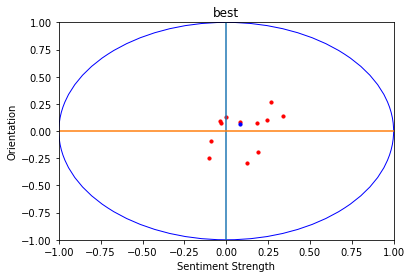

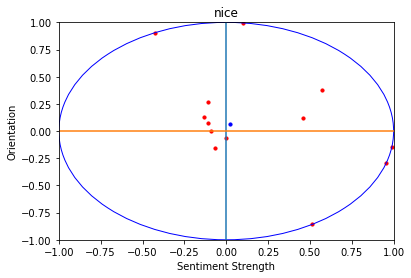

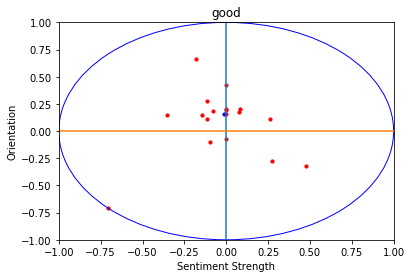

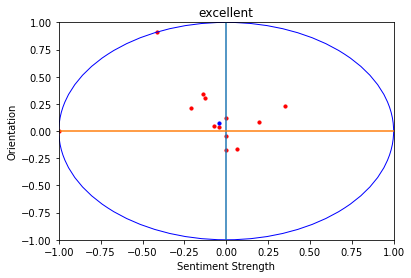

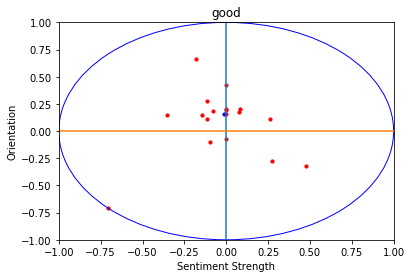

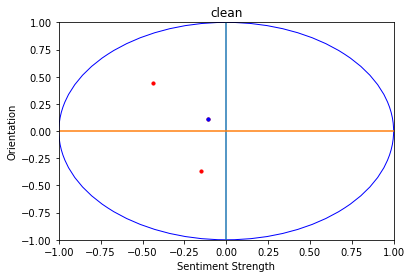

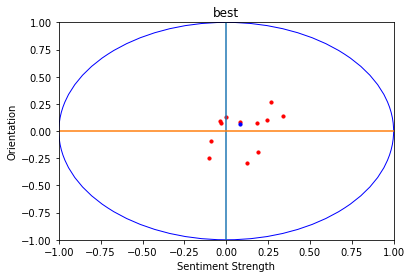

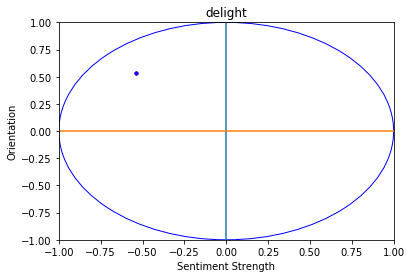

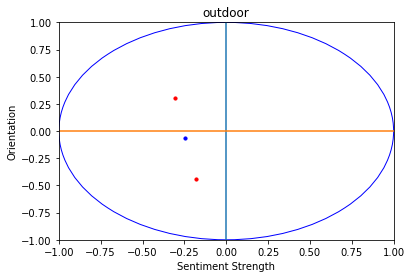

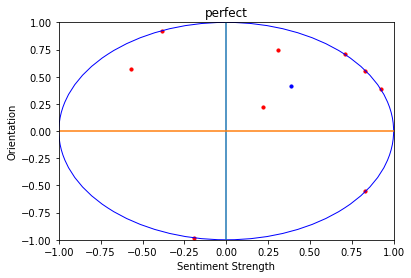

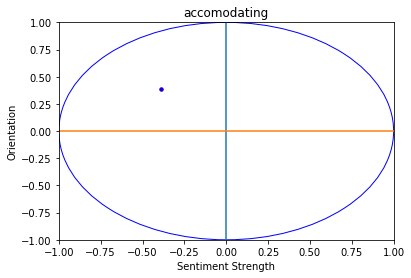

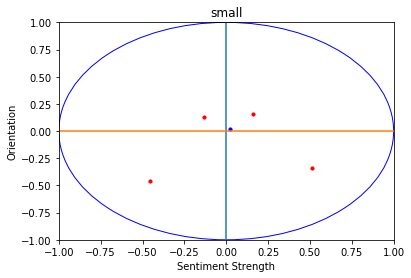

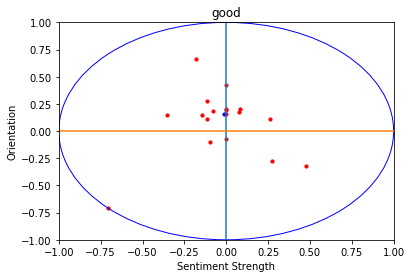

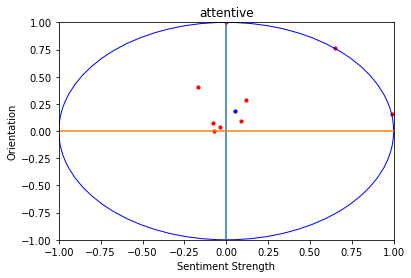

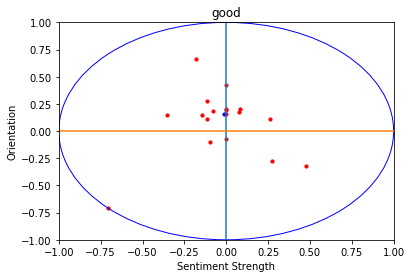

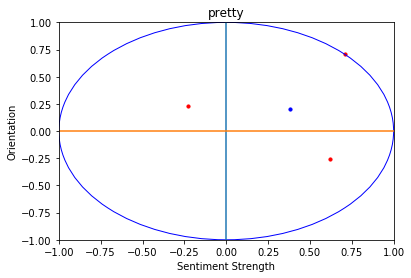

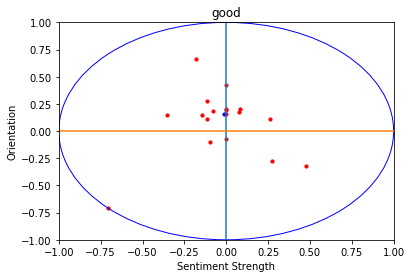

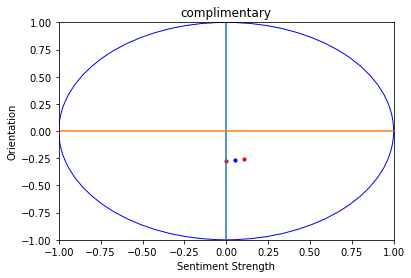

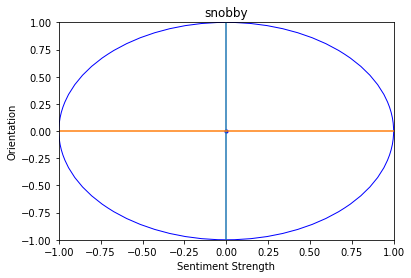

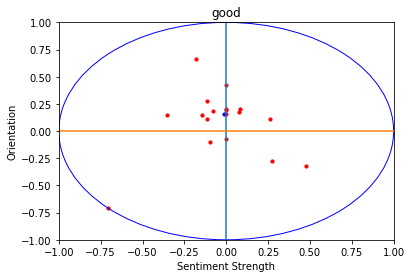

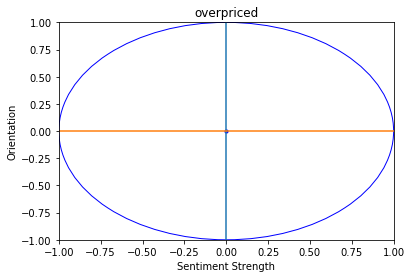

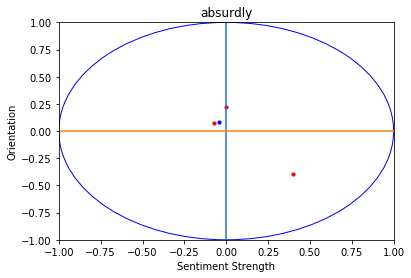

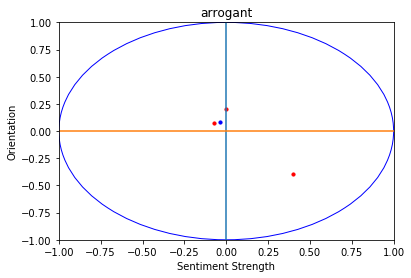

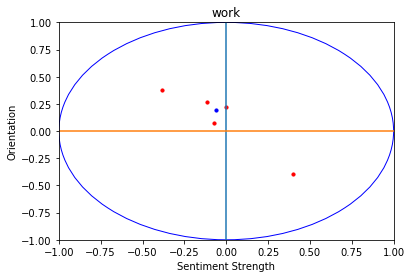

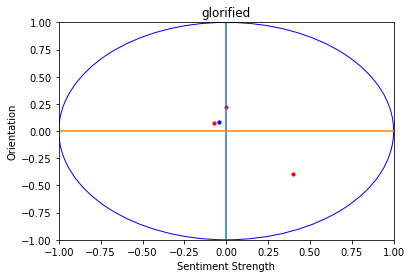

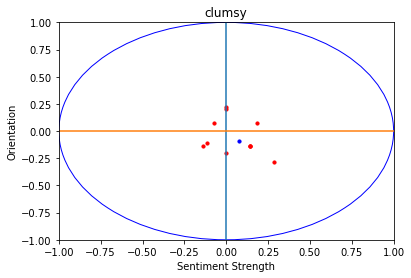

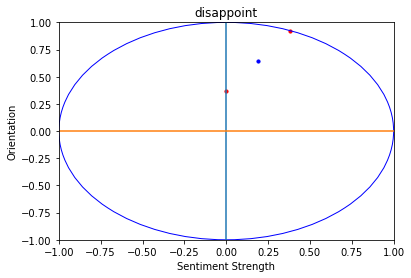

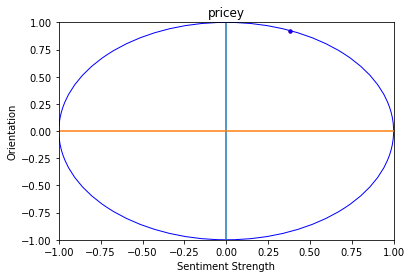

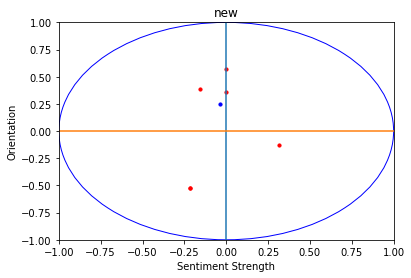

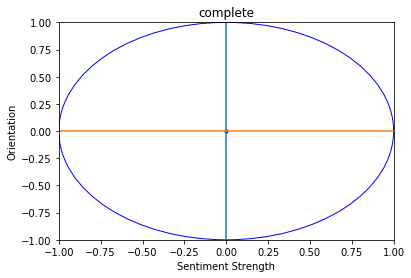

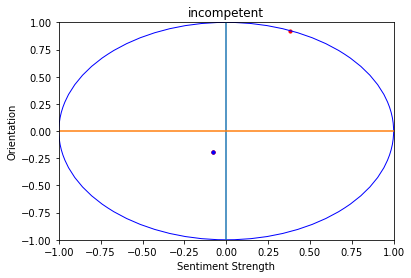

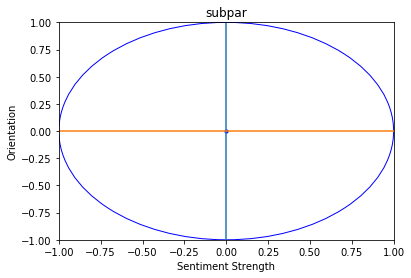

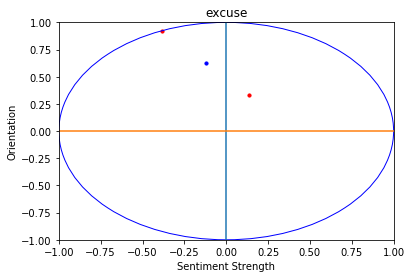

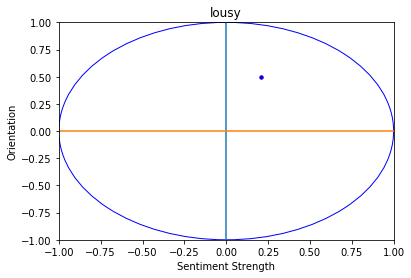

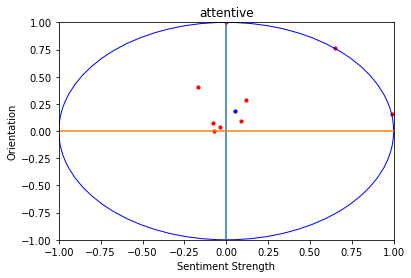

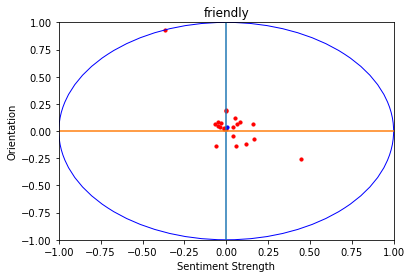

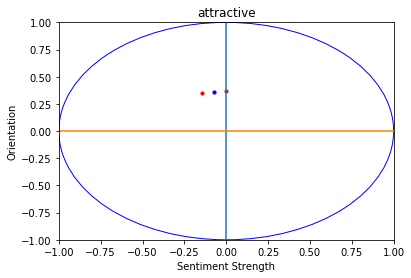

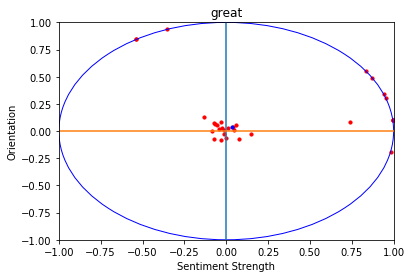

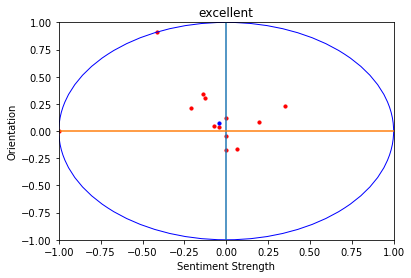

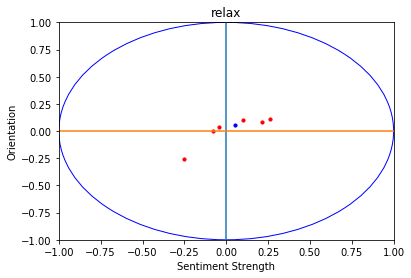

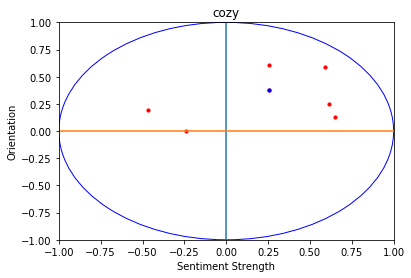

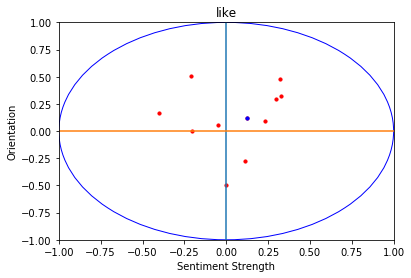

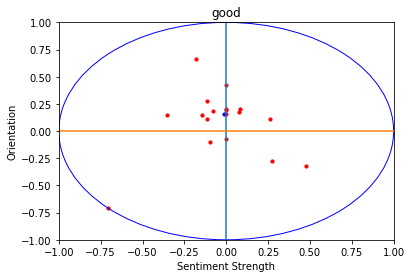

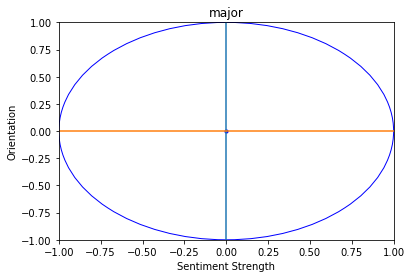

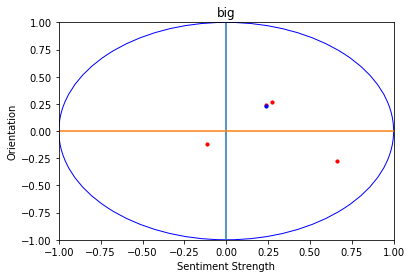

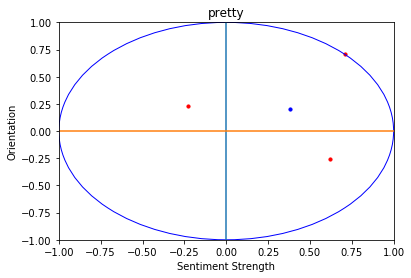

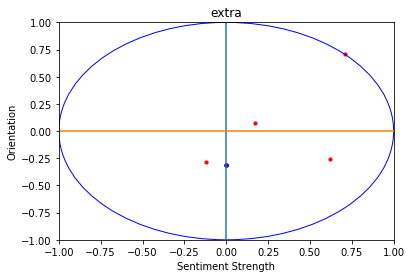

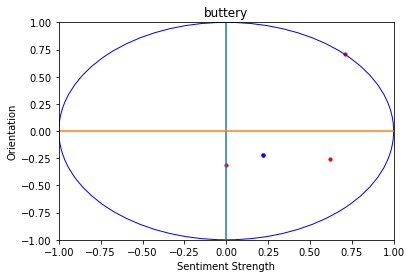

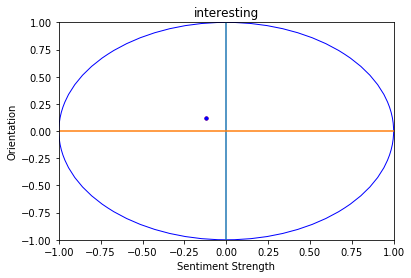

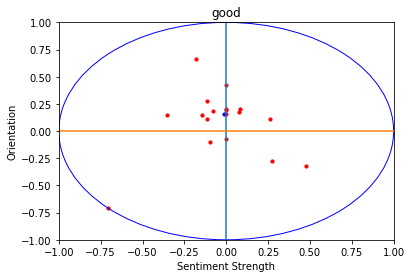

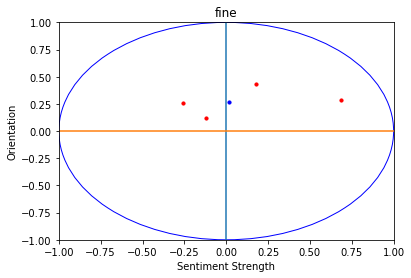

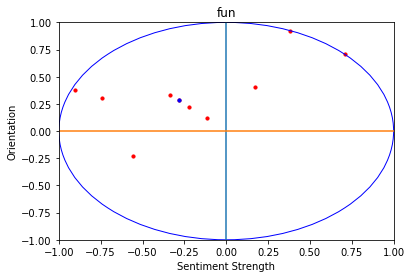

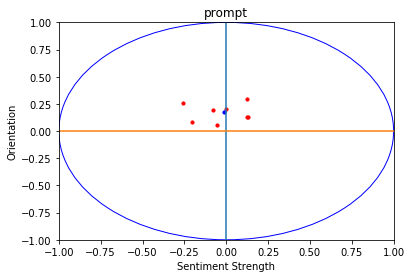

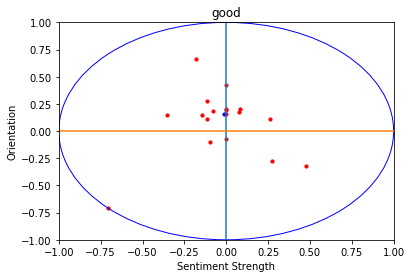

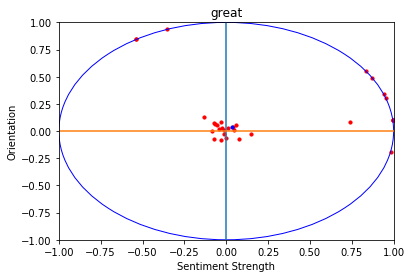

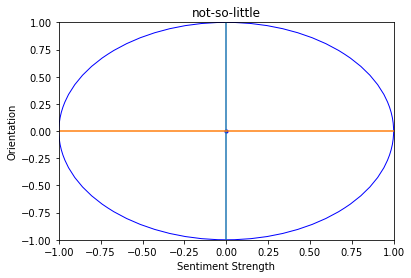

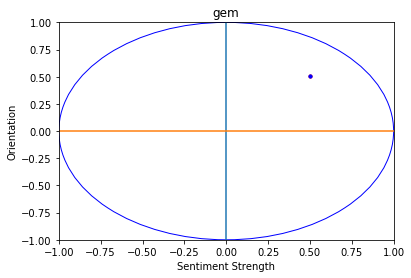

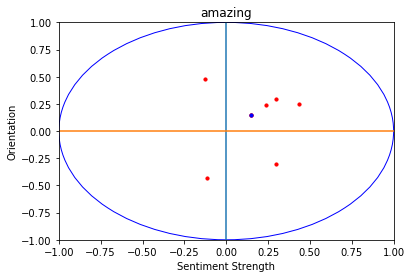

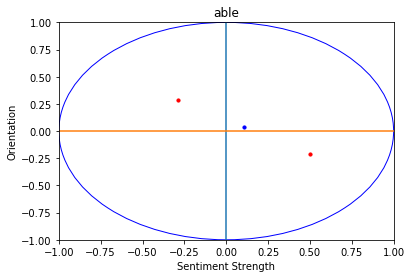

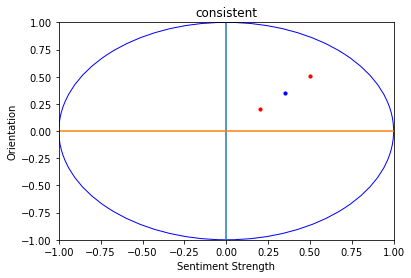

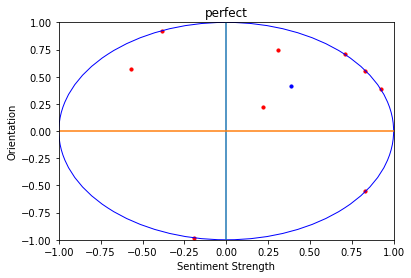

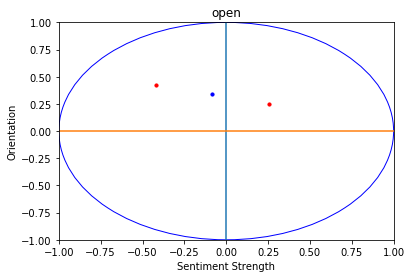

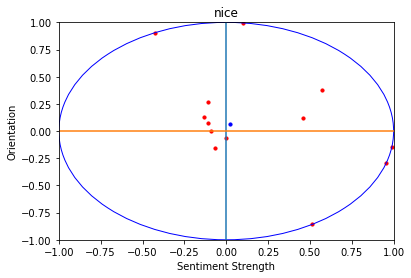

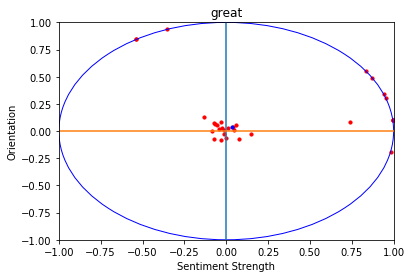

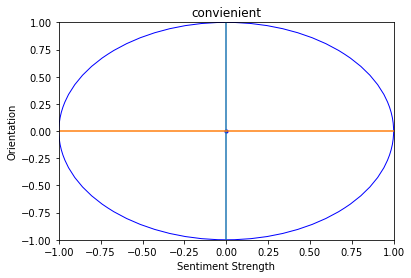

In [516]:
op_pred = []
op_score = []


memoize = {}
for i, opinion_sents in enumerate(data_service['opinion_term_prediction']):
    temp = []
    temp1 = []
    opinion_sents = ast.literal_eval(opinion_sents)
    for opinions in opinion_sents:
        polarity, senti_score = senti(opinions, data_service['preprocessed_sentence'].tolist(), data_service['preprocessed_sentence_lemma'].tolist(), True)
        temp.append(polarity)
        temp1.append(senti_score)
    op_pred.append(temp)
    op_score.append(temp1)
    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_service['opinion_prediction'] = op_pred
data_service['senti_score'] = op_score

In [366]:
sentiment_value = (confusion_metrix_sentiment_senticircle('VALUE', data_value)[6]) #+ confusion_metrix_sentiment_senticircle('negative', data_value)[6] ) / 2
print(sentiment_value)

0.779874213836478


In [367]:
sentiment_ambience = (confusion_metrix_sentiment_senticircle('AMBIENCE', data_ambience)[6])# + confusion_metrix_sentiment_senticircle('negative', data_ambience)[6] ) / 2
print(sentiment_ambience)

0.9096989966555183


In [368]:
sentiment_food = (confusion_metrix_sentiment_senticircle('FOOD', data_food)[6])# + confusion_metrix_sentiment_senticircle('negative', data_food)[6] ) / 2
print(sentiment_food)

0.7581395348837209


In [369]:
sentiment_service = (confusion_metrix_sentiment_senticircle('SERVICE', data_service)[6])# + confusion_metrix_sentiment_senticircle('negative', data_service)[6] ) / 2
print(sentiment_service)

0.8911917098445595


In [370]:
(sentiment_value + sentiment_ambience + sentiment_food + sentiment_service) / 4

0.8347261138050692

In [517]:
data_food.to_csv('SA2_food.csv')
data_ambience.to_csv('SA2_ambience.csv')
data_value.to_csv('SA2_value.csv')
data_service.to_csv('SA2_service.csv')

In [155]:
data_value.to_csv('hasil_value.csv')

SA3-1

In [325]:
op_pred = []
memoize = {}
for i, opinion_sents in enumerate(data_food['opinion_term_prediction']):
    temp = []
    opinion_sents = ast.literal_eval(opinion_sents)
    for opinions in opinion_sents:
        temp.append(senti(opinions, data_food['preprocessed_sentence'].tolist(), data_food['preprocessed_sentence_lemma'].tolist(), False, True))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_food['opinion_prediction'] = op_pred

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

In [326]:
op_pred = []
memoize = {}
for i, opinion_sents in enumerate(data_service['opinion_term_prediction']):
    temp = []
    opinion_sents = ast.literal_eval(opinion_sents)
    for opinions in opinion_sents:
        temp.append(senti(opinions, data_service['preprocessed_sentence'].tolist(), data_service['preprocessed_sentence_lemma'].tolist(), False, True))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_service['opinion_prediction'] = op_pred

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

In [327]:
op_pred = []
memoize = {}
for i, opinion_sents in enumerate(data_ambience['opinion_term_prediction']):
    temp = []
    opinion_sents = ast.literal_eval(opinion_sents)
    for opinions in opinion_sents:
        temp.append(senti(opinions, data_ambience['preprocessed_sentence'].tolist(), data_ambience['preprocessed_sentence_lemma'].tolist(), False, True))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_ambience['opinion_prediction'] = op_pred

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

In [328]:
op_pred = []
memoize = {}
for i, opinion_sents in enumerate(data_value['opinion_term_prediction']):
    temp = []
    opinion_sents = ast.literal_eval(opinion_sents)
    for opinions in opinion_sents:
        temp.append(senti(opinions, data_value['preprocessed_sentence'].tolist(), data_value['preprocessed_sentence_lemma'].tolist(), False, True))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_value['opinion_prediction'] = op_pred

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range


In [329]:
sentiment_value = (confusion_metrix_sentiment_senticircle('VALUE', data_value)[6]) #+ confusion_metrix_sentiment_senticircle('negative', data_value)[6] ) / 2
print(sentiment_value)

0.7692307692307692


In [330]:
sentiment_ambience = (confusion_metrix_sentiment_senticircle('AMBIENCE', data_ambience)[6])# + confusion_metrix_sentiment_senticircle('negative', data_ambience)[6] ) / 2
print(sentiment_ambience)

0.915032679738562


In [331]:
sentiment_food = (confusion_metrix_sentiment_senticircle('FOOD', data_food)[6])# + confusion_metrix_sentiment_senticircle('negative', data_food)[6] ) / 2
print(sentiment_food)

0.8092485549132947


In [332]:
sentiment_service = (confusion_metrix_sentiment_senticircle('SERVICE', data_service)[6])# + confusion_metrix_sentiment_senticircle('negative', data_service)[6] ) / 2
print(sentiment_service)

0.863849765258216


In [333]:
(sentiment_value + sentiment_ambience + sentiment_food + sentiment_service) / 4

0.8393404422852104

SA3-2

In [338]:
op_pred = []
memoize = {}
for i, opinion_sents in enumerate(data_food['opinion_term_prediction']):
    temp = []
    opinion_sents = ast.literal_eval(opinion_sents)
    for opinions in opinion_sents:
        temp.append(senti(opinions, data_food['preprocessed_sentence'].tolist(), data_food['preprocessed_sentence_lemma'].tolist(), True, True))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_food['opinion_prediction'] = op_pred

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range


In [339]:
op_pred = []
memoize = {}
for i, opinion_sents in enumerate(data_service['opinion_term_prediction']):
    temp = []
    opinion_sents = ast.literal_eval(opinion_sents)
    for opinions in opinion_sents:
        temp.append(senti(opinions, data_service['preprocessed_sentence'].tolist(), data_service['preprocessed_sentence_lemma'].tolist(), True, True))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_service['opinion_prediction'] = op_pred

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

In [340]:
op_pred = []
memoize = {}
for i, opinion_sents in enumerate(data_ambience['opinion_term_prediction']):
    temp = []
    opinion_sents = ast.literal_eval(opinion_sents)
    for opinions in opinion_sents:
        temp.append(senti(opinions, data_ambience['preprocessed_sentence'].tolist(), data_ambience['preprocessed_sentence_lemma'].tolist(), True, True))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_ambience['opinion_prediction'] = op_pred

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

In [346]:
data_food.to_csv('SA3_food.csv')
data_ambience.to_csv('SA3_ambience.csv')
data_value.to_csv('SA3_value.csv')
data_service.to_csv('SA3_service.csv')

In [341]:
sentiment_value = (confusion_metrix_sentiment_senticircle('VALUE', data_value)[6]) #+ confusion_metrix_sentiment_senticircle('negative', data_value)[6] ) / 2
print(sentiment_value)

0.7692307692307692


In [342]:
sentiment_ambience = (confusion_metrix_sentiment_senticircle('AMBIENCE', data_ambience)[6])# + confusion_metrix_sentiment_senticircle('negative', data_ambience)[6] ) / 2
print(sentiment_ambience)

0.9265175718849841


In [343]:
sentiment_food = (confusion_metrix_sentiment_senticircle('FOOD', data_food)[6])# + confusion_metrix_sentiment_senticircle('negative', data_food)[6] ) / 2
print(sentiment_food)

0.8275862068965518


In [344]:
sentiment_service = (confusion_metrix_sentiment_senticircle('SERVICE', data_service)[6])# + confusion_metrix_sentiment_senticircle('negative', data_service)[6] ) / 2
print(sentiment_service)

0.8651162790697675


In [345]:
(sentiment_value + sentiment_ambience + sentiment_food + sentiment_service) / 4

0.8471127067705182

In [295]:
data_value.to_csv('hasil_value.csv')

'negative'

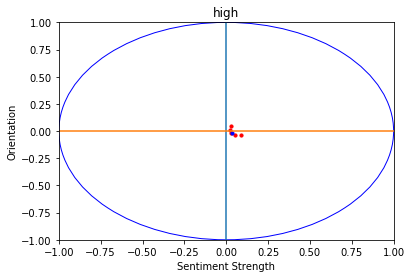

In [226]:
memoize={}
senti(['high'], data_value['preprocessed_sentence'], data_value['preprocessed_sentence_lemma'], True, True)

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range


('negative', -0.49991543016740064)

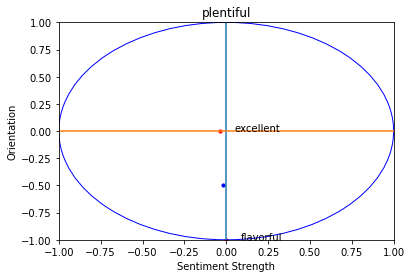

In [381]:
memoize={}
senti(['plentiful'], data_food['preprocessed_sentence'], data_food['preprocessed_sentence_lemma'])

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
{'food': 0.11340917164975181, 'flavorful': 0.3444323868065583, 'reasonably': 1.0, 'price': 0.27150143885661204, 'flavourful': 0.9366163143095235, 'flavorous': 0.9366163143095235, 'flavourous': 0.9366163143095235, 'flavorsome': 0.9366163143095235, 'flavoursome': 0.9366163143095235

('positive', 0.009297480704071204)

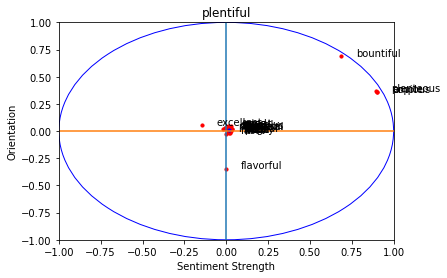

In [387]:
memoize={}
senti(['plentiful'], data_food['preprocessed_sentence'], data_food['preprocessed_sentence_lemma'], True, True)

In [59]:
simple_lesk('The food is flavorful, plentiful and reasonably priced.', 'flavorful', 'a')

Synset('flavorful.s.01')

In [150]:
pos_tag(nltk.word_tokenize('The food is flavorful, plentiful and reasonably priced'))

[('The', 'DT'),
 ('food', 'NN'),
 ('is', 'VBZ'),
 ('flavorful', 'JJ'),
 (',', ','),
 ('plentiful', 'JJ'),
 ('and', 'CC'),
 ('reasonably', 'RB'),
 ('priced', 'VBN')]

{'takeout': 0.7999999999999999, 'great': 0.7999999999999999, 'since': 0.39999999999999997, 'give': 0.7999999999999999, 'quality': 0.39999999999999997, 'tupperware': 0.39999999999999997, 'well': 0.39999999999999997, 'outstanding': 1.0, 'bully': 1.0, 'corking': 1.0, 'cracking': 1.0, 'dandy': 1.0, 'groovy': 1.0, 'keen': 1.0, 'neat': 1.0, 'nifty': 1.0, 'not_bad': 1.0, 'peachy': 1.0, 'swell': 1.0, 'smashing': 1.0, 'yield': 1.0, 'afford': 1.0, 'high': 0.7999999999999999} {'takeout': 0.0, 'great': 0.7853981633974483, 'since': 0.0, 'give': 0.0, 'quality': 0.0, 'tupperware': 0.0, 'well': 0.0, 'outstanding': 0.0, 'bully': 0.0, 'corking': 0.0, 'cracking': 0.0, 'dandy': 0.0, 'groovy': 0.0, 'keen': 0.0, 'neat': 0.0, 'nifty': 0.0, 'not_bad': 0.0, 'peachy': 0.0, 'swell': 0.0, 'smashing': 0.0, 'yield': 0.0, 'afford': 0.0, 'high': 0.39269908169872414}


('positive', 0.4359468345283157)

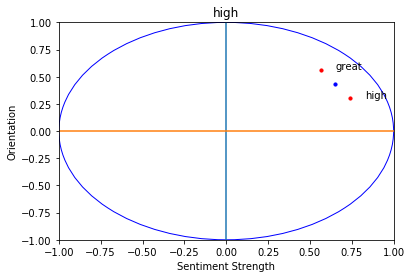

In [419]:
sent = ["the takeout is great too since they give high quality tupperware as well .", 
        "i highly recommend the Sophia pizza .",
        "i have to highly recommend the lobster roll - not to much mayo; you can tell it was a fresh lobster .",
       "i highly recommend Caviar Russe to anyone who wants delicious top grade caviar and fantastic service."]
sent_lemma = [
    "takeout great since give high quality tupperware well",
    "highly recommend sophia pizza",
    "highly recommend lobster roll much mayo tell fresh lobster"
    "highly recommend caviar russe anyone want delicious top grade caviar fantastic service"
]
memoize={}


senti(['high'], sent, sent_lemma, True, True)
#senti(['plentiful'], data_food['preprocessed_sentence'], data_food['preprocessed_sentence_lemma'], True, True)

{'price': 0.0, 'go': 0.21427798206014265, 'pay': 0.5356949551503567, 'view': 0.10713899103007132, 'food': 0.0586324932735557, 'travel': 0.25, 'move': 0.25, 'locomote': 0.25, 'give': 0.25, 'pay_up': 0.25, 'ante_up': 0.25, 'yield': 0.25, 'bear': 0.25, 'good': 0.18969642183207214, 'would': 0.09484821091603607, 'come': 0.4742410545801803, 'back': 0.09484821091603607, 'come_up': 0.25, 'arrive': 0.25, 'get': 0.25, 'cramped': 0.24335179694197406, 'unappealing': 0.24335179694197406, 'resturant': 0.12167589847098703, 'cramp': 1.0, 'hamper': 0.25, 'halter': 0.25, 'strangle': 0.25, 'unsympathetic': 0.25, 'unlikeable': 0.25, 'unlikable': 0.25, 'quality': 0.12167589847098703, 'horrible': 0.24335179694197406, 'atrocious': 0.25, 'frightful': 0.25, 'horrifying': 0.25, 'ugly': 0.25, 'high': 0.0} {'price': 0.0, 'go': 0.0, 'pay': 0.0, 'view': 0.0, 'food': 0.0, 'travel': 0.0, 'move': 0.0, 'locomote': 0.0, 'give': 0.0, 'pay_up': 0.0, 'ante_up': 0.0, 'yield': 0.0, 'bear': 0.0, 'good': 2.356194490192345, 'wo

('negative', -0.04711118009214392)

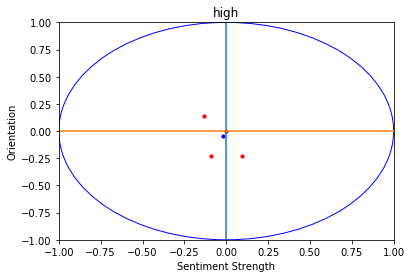

In [427]:
sent = [
    "The high prices you're going to pay is for the view not for the food",
    "Price is high but the food is good, so I would come back again",
    "Prices too high for this cramped and unappealing resturant.",
    "the price is high and the quality of food is horrible."
]

sent_lemma = [
    "high price go pay view food",
    "price high food good would come back",
    "price high cramped unappealing resturant",
    "price high quality food horrible"
]
memoize = {}
senti(['high'], sent, sent_lemma, True, True)

sentiwordnet

In [428]:
def predict_sentiwordnet(opinions, sent):
    endscore = 0
    for opinion in opinions:
        try:
            score = swn.senti_synset(opinion + '.a.1')
            if score.pos_score() > score.neg_score():
                endscore += score.pos_score()
            else:
                endscore += score.neg_score() * (-1)
            
            words = sent.split(' ')
            word_around = []
            for x in range(0, len(words)):
                if words[x] in string.punctuation:
                    continue
                try:
                    if (words[x+1] == opinion) or (words[x+2] == opinion) or (words[x+3] == opinion) or (words[x+4] == opinion):
                        word_around.append(words[x])
                    elif (words[x-1] == opinion):
                        word_around.append(words[x])
                except:
                    pass
            for neg in negation:
                if neg in word_around:
                    endscore *= (-1)
                    break
        except:
            pass
    if endscore > 0:
        polarity = 'positive'
    else:
        polarity = 'negative'
           
    return polarity

In [443]:
op_pred = []
for i, opinion_sents in enumerate(data_food['opinion_term_prediction']):
    temp = []
    review = data_food['review'][i]
    opinion_sents = ast.literal_eval(opinion_sents)
    
    for opinions in opinion_sents:
        temp.append(predict_sentiwordnet(opinions, review))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_food['opinion_prediction'] = op_pred

In [448]:
op_pred = []
for i, opinion_sents in enumerate(data_service['opinion_term_prediction']):
    temp = []
    review = data_service['review'][i]
    opinion_sents = ast.literal_eval(opinion_sents)
    
    for opinions in opinion_sents:
        temp.append(predict_sentiwordnet(opinions, review))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_service['opinion_prediction'] = op_pred

In [449]:
op_pred = []
for i, opinion_sents in enumerate(data_ambience['opinion_term_prediction']):
    temp = []
    review = data_ambience['review'][i]
    opinion_sents = ast.literal_eval(opinion_sents)
    
    for opinions in opinion_sents:
        temp.append(predict_sentiwordnet(opinions, review))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_ambience['opinion_prediction'] = op_pred

In [450]:
op_pred = []
for i, opinion_sents in enumerate(data_value['opinion_term_prediction']):
    temp = []
    review = data_value['review'][i]
    opinion_sents = ast.literal_eval(opinion_sents)
    
    for opinions in opinion_sents:
        temp.append(predict_sentiwordnet(opinions, review))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_value['opinion_prediction'] = op_pred

In [452]:
sentiment_value = (confusion_metrix_sentiment_senticircle('VALUE', data_value)[6]) #+ confusion_metrix_sentiment_senticircle('negative', data_value)[6] ) / 2
print(sentiment_value)

0.15533980582524273


In [453]:
sentiment_food = (confusion_metrix_sentiment_senticircle('FOOD', data_food)[6]) #+ confusion_metrix_sentiment_senticircle('negative', data_value)[6] ) / 2
print(sentiment_food)

0.6393442622950819


In [454]:
sentiment_ambience = (confusion_metrix_sentiment_senticircle('AMBIENCE', data_ambience)[6]) #+ confusion_metrix_sentiment_senticircle('negative', data_value)[6] ) / 2
print(sentiment_ambience)

0.5277777777777778


In [455]:
sentiment_service = (confusion_metrix_sentiment_senticircle('SERVICE', data_service)[6]) #+ confusion_metrix_sentiment_senticircle('negative', data_value)[6] ) / 2
print(sentiment_service)

0.7000000000000001


In [456]:
(sentiment_value + sentiment_ambience + sentiment_food + sentiment_service) / 4

0.5056154614745256

In [457]:
((confusion_metrix_sentiment_senticircle('VALUE', data_value)[4]) + (confusion_metrix_sentiment_senticircle('FOOD', data_value)[4]) + (confusion_metrix_sentiment_senticircle('AMBIENCE', data_value)[4]) + (confusion_metrix_sentiment_senticircle('SERVICE', data_value)[4])) / 4

0.8157407407407408

In [458]:
((confusion_metrix_sentiment_senticircle('VALUE', data_value)[5]) + (confusion_metrix_sentiment_senticircle('FOOD', data_value)[5]) + (confusion_metrix_sentiment_senticircle('AMBIENCE', data_value)[5]) + (confusion_metrix_sentiment_senticircle('SERVICE', data_value)[5])) / 4

0.26919178565133084

SEntiwordnet + WSD

In [459]:
def predict_sentiwordnet_lesk(opinions, sent):
    endscore = 0
    for opinion in opinions:
        try:
            op_with_tag = pos_tag(opinion)[0]
            if check_is_noun(op_with_tag[1]):
                score = swn.senti_synset(simple_lesk(sent, opinion, pos='n').name())
            elif check_is_adjective(op_with_tag[1]):
                score = swn.senti_synset(simple_lesk(sent, opinion, pos='a').name())
            elif check_is_verb(op_with_tag[1]):
                score = swn.senti_synset(simple_lesk(sent, opinion, pos='v').name())
            elif check_is_adverb(op_with_tag[1]):
                score = swn.senti_synset(simple_lesk(sent, opinion, pos='r').name())
            else:
                score = swn.senti_synset(simple_lesk(sent, opinion, pos='n').name())
                
            if score.pos_score() > score.neg_score():
                endscore += score.pos_score()
            else:
                endscore += score.neg_score() * (-1)
                
            words = sent.split(' ')
            word_around = []
            for x in range(0, len(words)):
                if words[x] in string.punctuation:
                    continue
                try:
                    if (words[x+1] == opinion) or (words[x+2] == opinion) or (words[x+3] == opinion) or (words[x+4] == opinion):
                        word_around.append(words[x])
                    elif (words[x-1] == opinion):
                        word_around.append(words[x])
                except:
                    pass
            
            for neg in negation:
                if neg in word_around:
                    endscore *= (-1)
                    break
           
        except Exception as e:
            #print(e)
            #print(opinion, sent, op_with_tag)
            pass
            
    if endscore > 0:
        polarity = 'positive'
    else:
        polarity = 'negative'
           
    return polarity

In [460]:
op_pred = []
for i, opinion_sents in enumerate(data_food['opinion_term_prediction']):
    temp = []
    review = data_food['review'][i]
    opinion_sents = ast.literal_eval(opinion_sents)
    
    for opinions in opinion_sents:
        temp.append(predict_sentiwordnet_lesk(opinions, review))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_food['opinion_prediction'] = op_pred

In [461]:
op_pred = []
for i, opinion_sents in enumerate(data_service['opinion_term_prediction']):
    temp = []
    review = data_service['review'][i]
    opinion_sents = ast.literal_eval(opinion_sents)
    
    for opinions in opinion_sents:
        temp.append(predict_sentiwordnet_lesk(opinions, review))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_service['opinion_prediction'] = op_pred

In [462]:
op_pred = []
for i, opinion_sents in enumerate(data_ambience['opinion_term_prediction']):
    temp = []
    review = data_ambience['review'][i]
    opinion_sents = ast.literal_eval(opinion_sents)
    
    for opinions in opinion_sents:
        temp.append(predict_sentiwordnet_lesk(opinions, review))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_ambience['opinion_prediction'] = op_pred

In [463]:
op_pred = []
for i, opinion_sents in enumerate(data_value['opinion_term_prediction']):
    temp = []
    review = data_value['review'][i]
    opinion_sents = ast.literal_eval(opinion_sents)
    
    for opinions in opinion_sents:
        temp.append(predict_sentiwordnet_lesk(opinions, review))
    op_pred.append(temp)

    #    op_pred.append(prediction_entity(sim_combined, category))
    #y_pred.append(aspect_predictions)

data_value['opinion_prediction'] = op_pred

In [464]:
((confusion_metrix_sentiment_senticircle('VALUE', data_value)[4]) + (confusion_metrix_sentiment_senticircle('FOOD', data_value)[4]) + (confusion_metrix_sentiment_senticircle('AMBIENCE', data_value)[4]) + (confusion_metrix_sentiment_senticircle('SERVICE', data_value)[4])) / 4

0.9763605442176871

In [465]:
((confusion_metrix_sentiment_senticircle('VALUE', data_value)[5]) + (confusion_metrix_sentiment_senticircle('FOOD', data_value)[5]) + (confusion_metrix_sentiment_senticircle('AMBIENCE', data_value)[5]) + (confusion_metrix_sentiment_senticircle('SERVICE', data_value)[5])) / 4

0.5317072095892825

In [466]:
((confusion_metrix_sentiment_senticircle('VALUE', data_value)[6]) + (confusion_metrix_sentiment_senticircle('FOOD', data_value)[6]) + (confusion_metrix_sentiment_senticircle('AMBIENCE', data_value)[6]) + (confusion_metrix_sentiment_senticircle('SERVICE', data_value)[6])) / 4

0.6485351965072869

perhitungan aspect bases sentiment analisis

In [485]:
data_sa3_food = pd.read_csv('SA3_food.csv')
data_sa3_ambience = pd.read_csv('SA3_ambience.csv')
data_sa3_service = pd.read_csv('SA3_service.csv')
data_sa3_value = pd.read_csv('SA3_value.csv')

food

In [493]:
total_pos = 0
total_neg = 0

for i, predictions in enumerate(data_sa3_food['opinion_prediction']):
    entity_predictions =  ast.literal_eval(data_sa3_food['entity_prediction'][i])
    entities = data_sa3_food['entity'][i].split(',')
    predictions = ast.literal_eval(predictions)
    for index, pred in enumerate(predictions):
       # print(pred)
        if entity_predictions[index] == 'FOOD':
            if pred == 'positive':
                total_pos += 1
            else:
                total_neg += 1

print(total_pos, total_neg)  

374 37


In [494]:
total_pos = 0
total_neg = 0

for i, predictions in enumerate(data_sa3_ambience['opinion_prediction']):
    entity_predictions =  ast.literal_eval(data_sa3_ambience['entity_prediction'][i])
    entities = data_sa3_ambience['entity'][i].split(',')
    predictions = ast.literal_eval(predictions)
    for index, pred in enumerate(predictions):
       # print(pred)
        if entity_predictions[index] == 'AMBIENCE':
            if pred == 'positive':
                total_pos += 1
            else:
                total_neg += 1

print(total_pos, total_neg)  

243 12


In [495]:
total_pos = 0
total_neg = 0

for i, predictions in enumerate(data_sa3_service['opinion_prediction']):
    entity_predictions =  ast.literal_eval(data_sa3_service['entity_prediction'][i])
    entities = data_sa3_service['entity'][i].split(',')
    predictions = ast.literal_eval(predictions)
    for index, pred in enumerate(predictions):
       # print(pred)
        if entity_predictions[index] == 'SERVICE':
            if pred == 'positive':
                total_pos += 1
            else:
                total_neg += 1

print(total_pos, total_neg)  

158 16


In [497]:
total_pos = 0
total_neg = 0

for i, predictions in enumerate(data_sa3_value['opinion_prediction']):
    entity_predictions =  ast.literal_eval(data_sa3_value['entity_prediction'][i])
    entities = data_sa3_value['entity'][i].split(',')
    predictions = ast.literal_eval(predictions)
    for index, pred in enumerate(predictions):
       # print(pred)
        if entity_predictions[index] == 'VALUE':
            if pred == 'positive':
                total_pos += 1
            else:
                total_neg += 1

print(total_pos, total_neg)  

87 60


In [498]:
374+37+243+12+158+16+87+60

987

In [506]:
60/987

0.060790273556231005

pembagian MCDM

In [544]:
restoran = {}

In [545]:
data_ambience = pd.read_csv('SA2_ambience.csv')
import pandas as pd
import numpy as np
NUMBER_OF_SPLITS = 10
for i, new_df in enumerate(np.array_split(data_ambience,NUMBER_OF_SPLITS)):
    restoran.setdefault(i, {'ambience': 0, 'service': 0, 'value': 0, 'food': 0})
    new_df = new_df.reset_index(drop=True)
    for index, scores in enumerate(new_df['senti_score']):
        try:
            entity_predictions =  ast.literal_eval(new_df['entity_prediction'][index])
    
            scores = ast.literal_eval(scores)
            for j, score in enumerate(scores):
                if entity_predictions[j] == 'AMBIENCE':
                    restoran[i]['ambience'] += score
                elif entity_predictions[j] == 'VALUE':
                    restoran[i]['value'] += score
                elif entity_predictions[j] == 'FOOD':
                    restoran[i]['food'] += score
                elif entity_predictions[j] == 'SERVICE':
                    restoran[i]['service'] += score
                
        except:
            pass
        

In [546]:
data_service = pd.read_csv('SA2_service.csv')
import pandas as pd
import numpy as np
NUMBER_OF_SPLITS = 10
for i, new_df in enumerate(np.array_split(data_service,NUMBER_OF_SPLITS)):
    restoran.setdefault(i, {'ambience': 0, 'service': 0, 'value': 0, 'food': 0})
    new_df = new_df.reset_index(drop=True)
    for index, scores in enumerate(new_df['senti_score']):
        try:
            entity_predictions =  ast.literal_eval(new_df['entity_prediction'][index])
    
            scores = ast.literal_eval(scores)
            for j, score in enumerate(scores):
                if entity_predictions[j] == 'AMBIENCE':
                    restoran[i]['ambience'] += score
                elif entity_predictions[j] == 'VALUE':
                    restoran[i]['value'] += score
                elif entity_predictions[j] == 'FOOD':
                    restoran[i]['food'] += score
                elif entity_predictions[j] == 'SERVICE':
                    restoran[i]['service'] += score
                
        except:
            pass
        

In [547]:
data_food = pd.read_csv('SA2_food.csv')
import pandas as pd
import numpy as np
NUMBER_OF_SPLITS = 10
for i, new_df in enumerate(np.array_split(data_food,NUMBER_OF_SPLITS)):
    restoran.setdefault(i, {'ambience': 0, 'service': 0, 'value': 0, 'food': 0})
    new_df = new_df.reset_index(drop=True)
    for index, scores in enumerate(new_df['senti_score']):
        try:
            entity_predictions =  ast.literal_eval(new_df['entity_prediction'][index])
    
            scores = ast.literal_eval(scores)
            for j, score in enumerate(scores):
                if entity_predictions[j] == 'AMBIENCE':
                    restoran[i]['ambience'] += score
                elif entity_predictions[j] == 'VALUE':
                    restoran[i]['value'] += score
                elif entity_predictions[j] == 'FOOD':
                    restoran[i]['food'] += score
                elif entity_predictions[j] == 'SERVICE':
                    restoran[i]['service'] += score
                
        except:
            pass
        

In [548]:
data_value = pd.read_csv('SA2_value.csv')
import pandas as pd
import numpy as np
NUMBER_OF_SPLITS = 10
for i, new_df in enumerate(np.array_split(data_value,NUMBER_OF_SPLITS)):
    restoran.setdefault(i, {'ambience': 0, 'service': 0, 'value': 0, 'food': 0})
    new_df = new_df.reset_index(drop=True)
    for index, scores in enumerate(new_df['senti_score']):
        try:
            entity_predictions =  ast.literal_eval(new_df['entity_prediction'][index])
    
            scores = ast.literal_eval(scores)
            for j, score in enumerate(scores):
                if entity_predictions[j] == 'AMBIENCE':
                    restoran[i]['ambience'] += score
                elif entity_predictions[j] == 'VALUE':
                    restoran[i]['value'] += score
                elif entity_predictions[j] == 'FOOD':
                    restoran[i]['food'] += score
                elif entity_predictions[j] == 'SERVICE':
                    restoran[i]['service'] += score
                
        except:
            pass
        

In [549]:
restoran

{0: {'ambience': 1.3751621977124475,
  'service': -0.3657964891385404,
  'value': -3.549422997627499,
  'food': -3.5573534788207977},
 1: {'ambience': 1.604832232566242,
  'service': 0.6814329274924081,
  'value': 2.278939748259115,
  'food': 3.9026963357428146},
 2: {'ambience': 5.419075868048291,
  'service': 0.16962991829117235,
  'value': 1.9088668876147463,
  'food': 1.2603749095513965},
 3: {'ambience': 5.085189688871836,
  'service': 2.2482863643491062,
  'value': 0.24513872869738196,
  'food': -2.783953068082501},
 4: {'ambience': 5.399203515580423,
  'service': 2.0291089117166217,
  'value': 1.0111768668682766,
  'food': -5.968395481946983},
 5: {'ambience': 3.3424764567465854,
  'service': 2.3954083253737743,
  'value': 0.8195796743888816,
  'food': -2.412240453209646},
 6: {'ambience': 5.178749615510742,
  'service': 2.0295943084655295,
  'value': 1.8501058534255281,
  'food': 4.6821923467812585},
 7: {'ambience': 2.3048294753424647,
  'service': 1.9130780008189352,
  'value

In [521]:
data_food = pd.read_csv('SA2_food.csv')
import pandas as pd
import numpy as np

NUMBER_OF_SPLITS = 10
for i, new_df in enumerate(np.array_split(data_food,NUMBER_OF_SPLITS)):
    with open(f"restoran_food{i}.csv","w") as fo:
            fo.write(new_df.to_csv())

In [522]:
data_value = pd.read_csv('SA2_value.csv')
import pandas as pd
import numpy as np

NUMBER_OF_SPLITS = 10
for i, new_df in enumerate(np.array_split(data_value,NUMBER_OF_SPLITS)):
    with open(f"restoran_value{i}.csv","w") as fo:
            fo.write(new_df.to_csv())